<h1><font color=darkred size=6><center> $\fbox{Classification Multimodale - Rakuten}$ </center></h1>
<font color=dimgrey size=3><center> $Bryan, \space Rizlène, \space Romain\space et \space Steeve$ </center></h1>

# Table des matières

## [Importation des librairies](#Imp)

## [Prediction](#Prediction)

## [Enrichissement du jeu de données textuels](#Enrichissement)

## [Bibliographies](#Bibli)

<h2><font size=6> Importation des librairies<a name="Imp"></a></h2>

In [1]:
import os
import csv
import warnings

from PIL import Image, ImageFilter
from IPython.display import display
import numpy as np
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import seaborn as sns
import cv2
from ultralytics import YOLO
#from torchvision import transforms

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 500
pd.options.display.max_columns = None

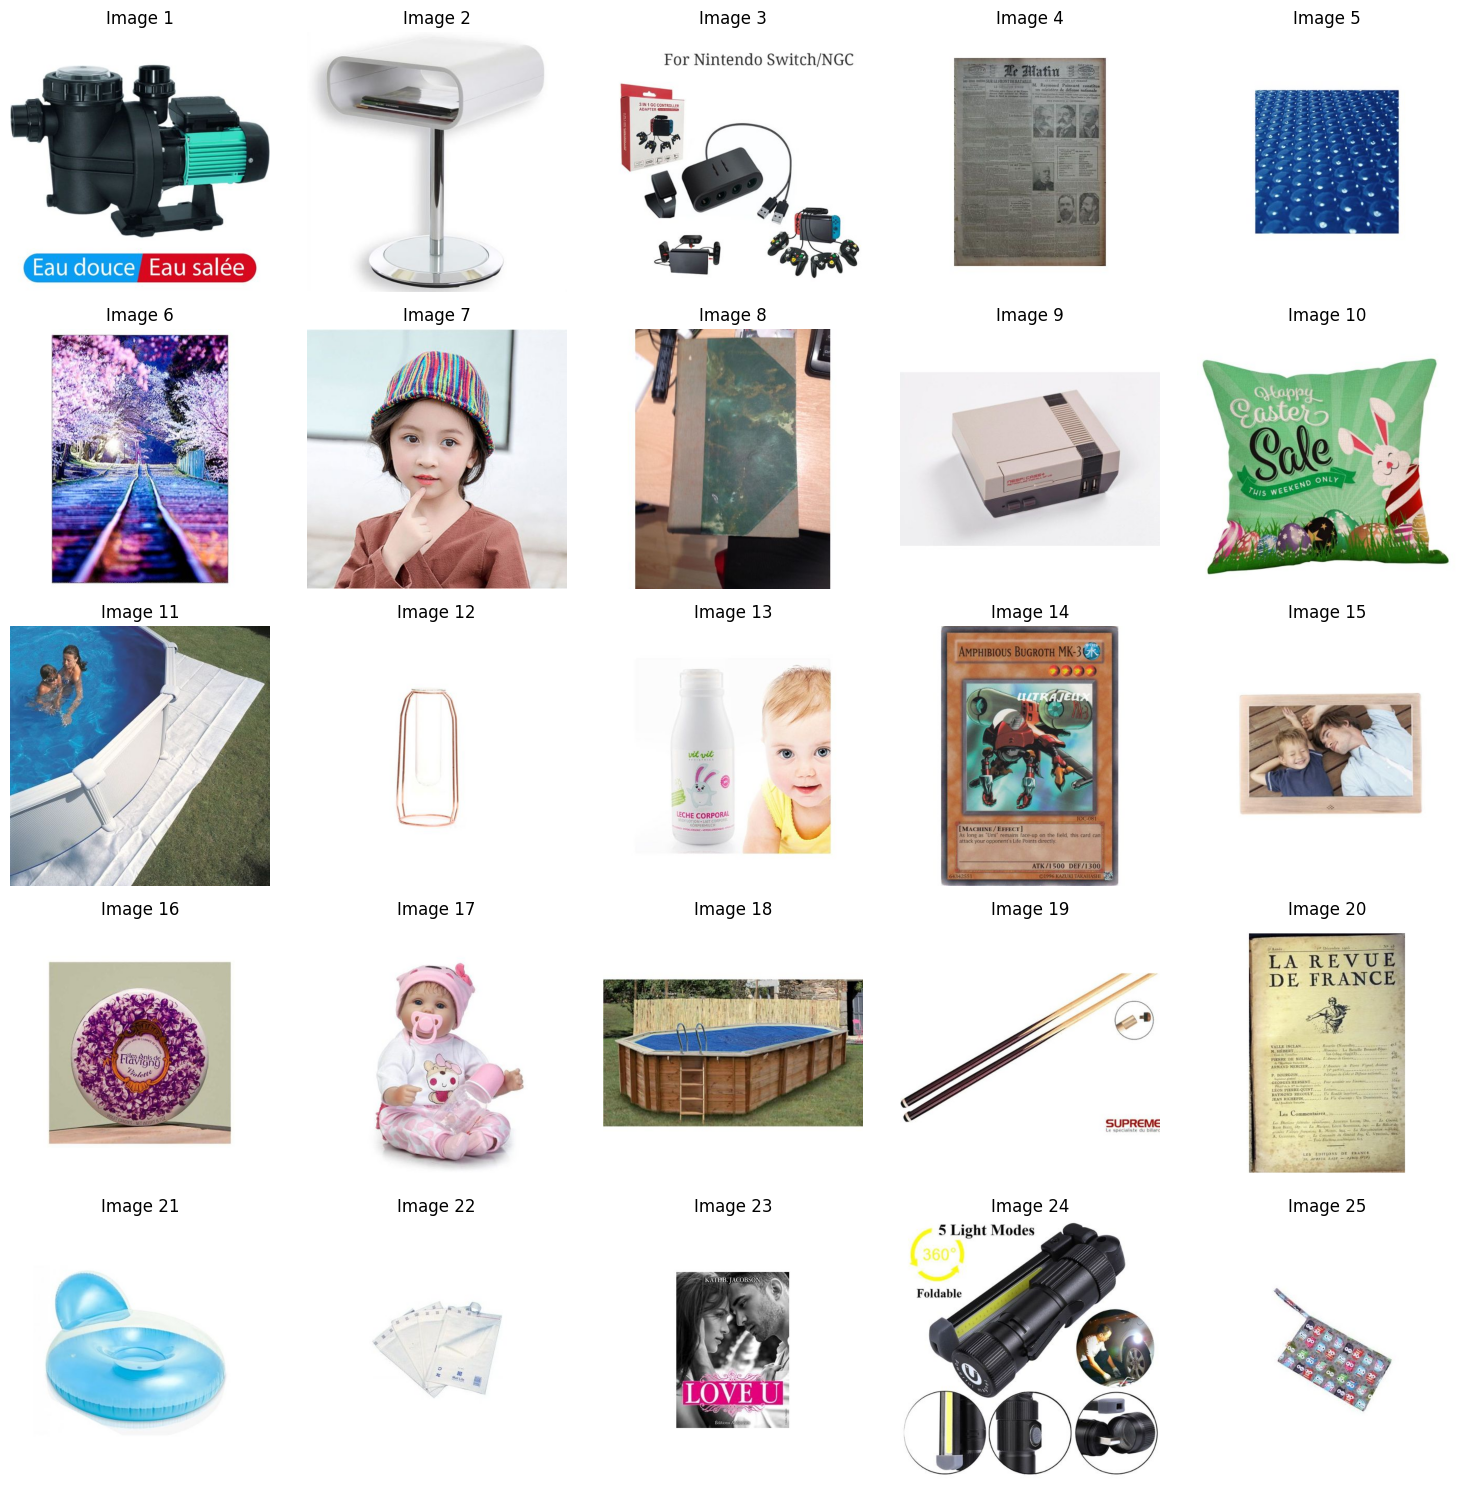

In [2]:
# Chemin vers le dossier contenant les images
dossier_images = "/Users/grizzly/Desktop/DataScientest/rakuten-multimodal-classification/data/images/image_train"

# Liste des fichiers dans le dossier
fichiers_images = os.listdir(dossier_images)

# Filtrer pour ne garder que les fichiers d'images (par exemple, .jpg)
fichiers_images = [f for f in fichiers_images if f.endswith('.jpg')]

# Prendre les 25 premières images
images_a_afficher = fichiers_images[:25]

# Créer une figure pour afficher les images
plt.figure(figsize=(15, 15))

for i, fichier in enumerate(images_a_afficher):
    # Ouvrir l'image
    image = Image.open(os.path.join(dossier_images, fichier))

    # Ajouter une sous-figure
    plt.subplot(5, 5, i + 1)  # 2 lignes, 3 colonnes
    plt.imshow(image)
    plt.axis('off')  # Ne pas afficher les axes
    plt.title(f"Image {i+1}")  # Titre avec le nom du fichier

# Afficher toutes les images
plt.tight_layout()
plt.show()

(Sauvegarder en tant que yolo_img1.png)

Description du modèle : 

Le modèle YOLO (You Only Look Once) est un modèle de détection d'objets qui a été entraîné sur 80 classes différentes. 

Fonctionnalités du modèle : 
- Détection d'objets : YOLO permet d'identifier et de localiser plusieurs objets dans une image en une seule passe, ce qui le rend plus rapide que d'autres méthodes de détection.
- Précision : Grâce à son architecture unique, YOLO offre une bonne précision dans la détection des objets, même dans des environnements complexes.


Nous avons eu l'idée d'utiliser le modèle YOLO pour enrichir notre jeu de données textuels. En effet, en effectuant une prédiction sur chaque image à l'aide de YOLO, nous pourrions ajouter des informations supplémentaires concernant les objets détectés. Cela pourrait aider notre modèle final à mieux comprendre le contenu des images et à prédire la bonne classe associée à chaque image.

Regardons les prédictions du modèle YOLO sur nos 25 premières images.

<h2><font size=6> Prediction <a name="Prediction"></a></h2>

In [3]:
# Charger le modèle YOLOv11
yolo_model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 32.8MB/s]


In [4]:
# Liste des classes YOLOv5
noms_classes_en = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", 
    "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", 
    "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", 
    "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", 
    "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", 
    "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", 
    "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", 
    "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", 
    "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", 
    "dining table", "toilet", "TV", "laptop", "mouse", "remote", "keyboard", 
    "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", 
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", 
    "toothbrush"
]

noms_classes_fr = [
    "personne", "bicyclette", "voiture", "moto", "avion", "autobus", "train", 
    "camion", "bateau", "feu de circulation", "hydrant", "panneau stop", "parcmètre", 
    "banc", "oiseau", "chat", "chien", "cheval", "mouton", "vache", "éléphant", 
    "ours", "zèbre", "girafe", "sac à dos", "parapluie", "sac à main", "cravate", 
    "valise", "frisbee", "skis", "snowboard", "ballon de sport", "cerf-volant", 
    "batte de baseball", "gant de baseball", "skateboard", "planche de surf", "raquette de tennis", 
    "bouteille", "verre à vin", "tasse", "fourchette", "couteau", "cuillère", "bol", 
    "banane", "pomme", "sandwich", "orange", "brocoli", "carotte", "hot dog", 
    "pizza", "beignet", "gâteau", "chaise", "canapé", "plante en pot", "lit", 
    "table à manger", "toilette", "TV", "ordinateur portable", "souris", "télécommande", "clavier", 
    "téléphone portable", "micro-ondes", "four", "grille-pain", "évier", "réfrigérateur", 
    "livre", "horloge", "vase", "ciseaux", "ours en peluche", "sèche-cheveux", 
    "brosse à dents"
]

# Créer le dossier yolo_pred s'il n'existe pas
dossier_pred = '../data/yolo_pred_img'
os.makedirs(dossier_pred, exist_ok=True)

for i, fichier in enumerate(images_a_afficher):
    print(f"\nImage {i+1}/25 :")
    results = yolo_model(os.path.join(dossier_images, fichier))  # Prédire sur une image

    for result in results:
        # Obtenir les boîtes, les scores et les classes
        boxes = result.boxes  # Obtenir les boîtes englobantes
        scores = boxes.conf  # Obtenir les scores de confiance
        classes = boxes.cls  # Obtenir les classes détectées

        # Charger l'image pour l'affichage
        image_path = os.path.join(dossier_images, fichier)
        image = cv2.imread(image_path)
        # Convertir BGR à RGB pour Matplotlib
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Dessiner les boîtes englobantes sur l'image
        for j in range(len(boxes)):
            box = boxes.xyxy[j].numpy()  # Convertir en numpy array
            cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)  # Boîte rouge
            nom_classe = noms_classes_fr[int(classes[j])]  # Obtenir le nom de la classe
            cv2.putText(image, f"{nom_classe}: {scores[j]:.2f}", (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Enregistrer l'image avec les boîtes dans le dossier yolo_pred
        output_path = os.path.join(dossier_pred, f"pred_{i+1}_{fichier}")
        cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Convertir RGB à BGR pour OpenCV



Image 1/25 :

image 1/1 /Users/grizzly/Desktop/DataScientest/rakuten-multimodal-classification/data/images/image_train/image_1174594490_product_2940640728.jpg: 640x640 3 suitcases, 771.7ms
Speed: 41.8ms preprocess, 771.7ms inference, 54.2ms postprocess per image at shape (1, 3, 640, 640)

Image 2/25 :

image 1/1 /Users/grizzly/Desktop/DataScientest/rakuten-multimodal-classification/data/images/image_train/image_1172460449_product_185143847.jpg: 640x640 (no detections), 374.5ms
Speed: 4.9ms preprocess, 374.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

Image 3/25 :

image 1/1 /Users/grizzly/Desktop/DataScientest/rakuten-multimodal-classification/data/images/image_train/image_1313553701_product_4199252811.jpg: 640x640 3 cell phones, 1 book, 3049.3ms
Speed: 6.7ms preprocess, 3049.3ms inference, 34.9ms postprocess per image at shape (1, 3, 640, 640)

Image 4/25 :

image 1/1 /Users/grizzly/Desktop/DataScientest/rakuten-multimodal-classification/data/images/image_trai

Comme mentionné précédemment, le modèle YOLO nous permet de localiser plusieurs objets dans une image, accompagnés de leur probabilité de détection. Affichons nos prédictions :

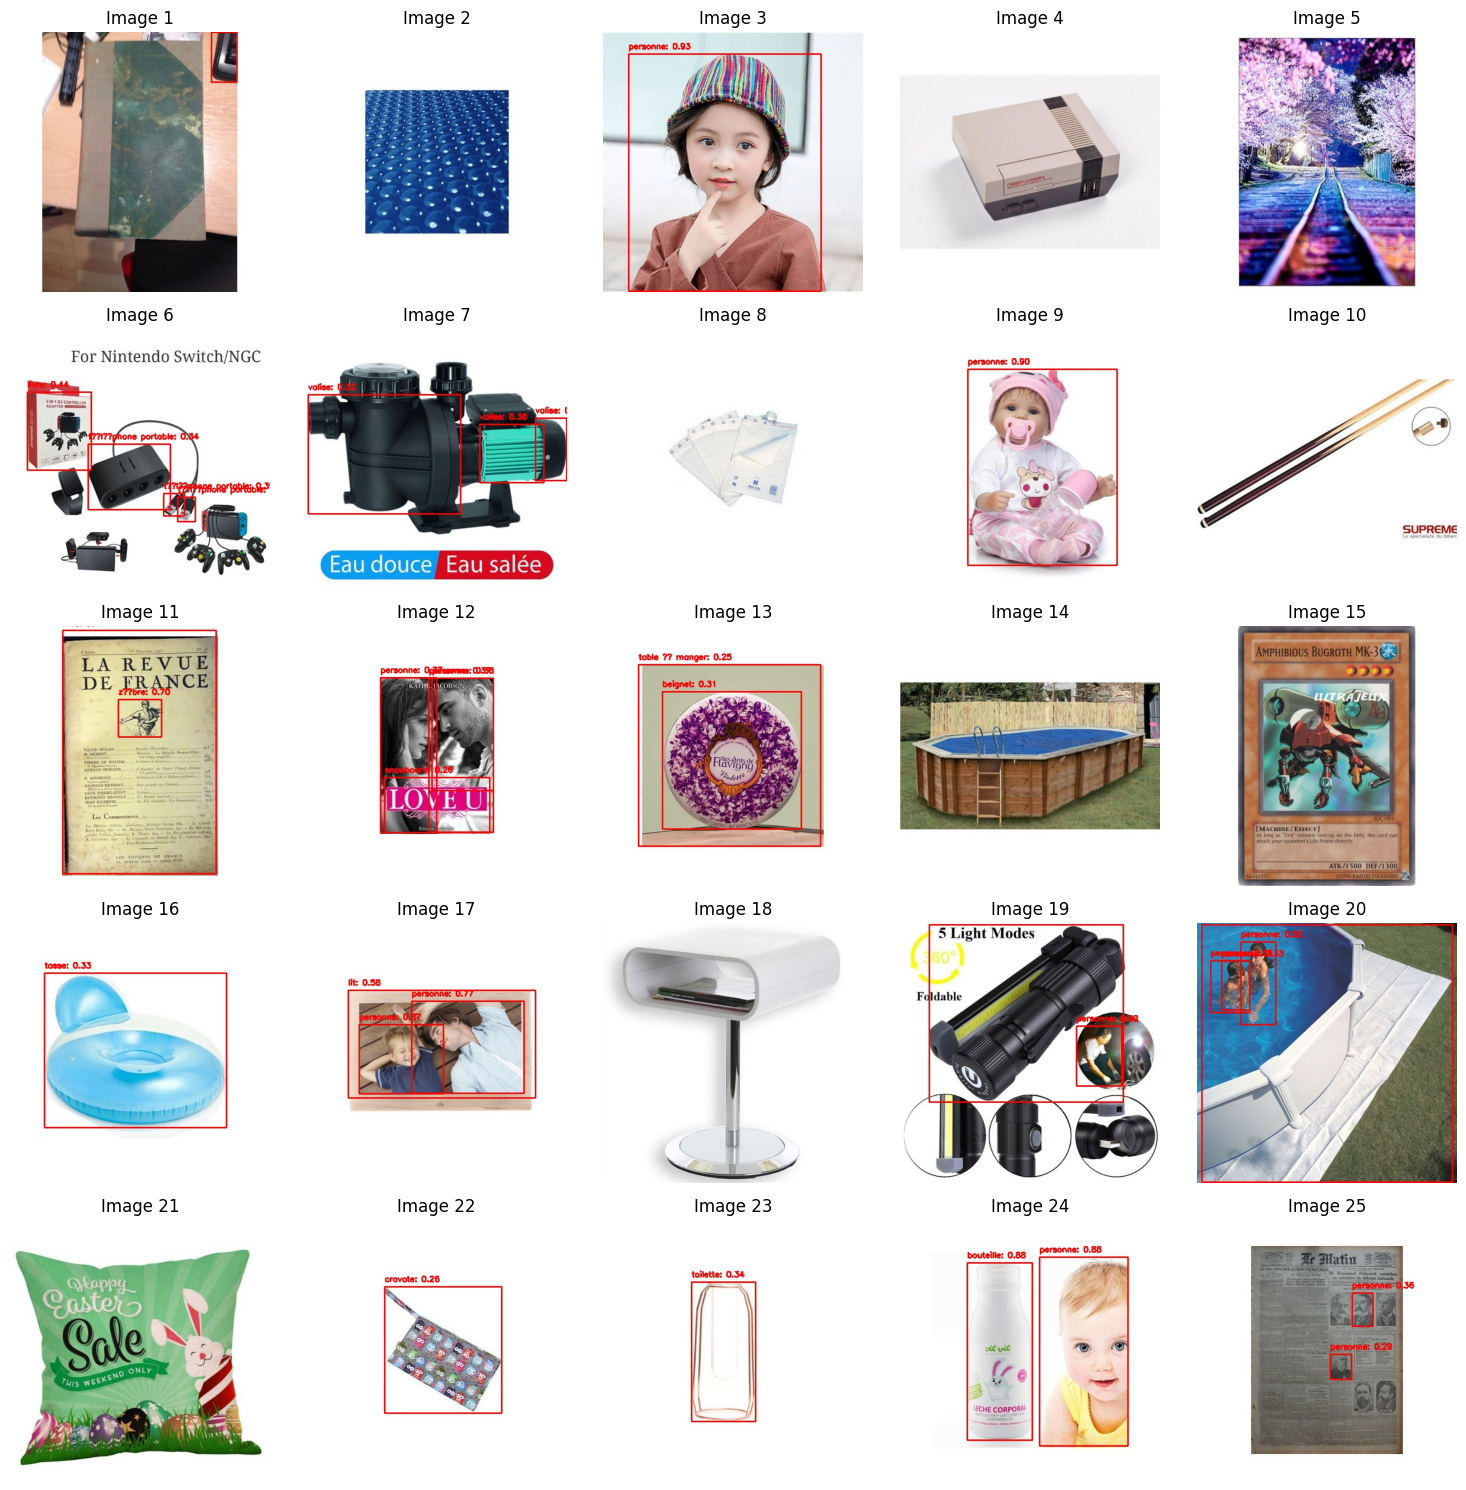

In [5]:
# Chemin vers le dossier contenant les images
dossier_images_yolo = "/Users/grizzly/Desktop/DataScientest/rakuten-multimodal-classification/data/yolo_pred_img"

# Liste des fichiers dans le dossier
fichiers_images_yolo = os.listdir(dossier_images_yolo)

# Filtrer pour ne garder que les fichiers d'images (par exemple, .jpg)
fichiers_images_yolo = [f for f in fichiers_images_yolo if f.endswith('.jpg')]

# Prendre les 25 premières images
images_a_afficher_yolo = fichiers_images_yolo

# Créer une figure pour afficher les images
plt.figure(figsize=(15, 15))

for i, fichier in enumerate(images_a_afficher_yolo):
    # Ouvrir l'image
    image = Image.open(os.path.join(dossier_images_yolo, fichier))

    # Ajouter une sous-figure
    plt.subplot(5, 5, i + 1)  # 2 lignes, 3 colonnes
    plt.imshow(image)
    plt.axis('off')  # Ne pas afficher les axes
    plt.title(f"Image {i+1}")  # Titre avec le nom du fichier

# Afficher toutes les images
plt.tight_layout()
plt.show()

(Sauvegarder en tant que yolo_img2.png)

On remarque que le modèle est très performant lorsqu'il s'agit de localiser des personnes. En effet, sur les 25 images présentées, il a réussi à détecter toutes les personnes présentes. Cependant, un problème se pose : sur certaines images (comme l'image 25, par exemple), la détection de personnes ne nous aide pas, au contraire. Cela peut donner l'impression que l'objet détecté pourrait être mis dans la même catégorie que l'image 3, alors que l'image 3 représente effectivement une personne, tandis que l'image 25 montre un journal. En somme, le modèle nous fournit une information secondaire en la considérant comme une information principale, ce qui peut prêter à confusion.

De plus, le modèle YOLO peut ne rien détecter (comme par exemple sur les images 1, 2, 4, etc.) ou se tromper. En effet, sur l'image 16, le modèle détecte un verre alors que l'image montre une bouée.

<h2><font size=6> Enrichissement du jeu de données textuels<a name="Enrichissement"></a></h2>

In [6]:
import pandas as pd

# Supposons que vos DataFrames sont déjà chargés comme suit :
X_train = pd.read_csv("../data/X_train_update.csv")
Y_train = pd.read_csv("../data/Y_train.csv")
yolo_pred = pd.read_csv("../data/yolo_pred1.csv")

# Réinitialiser l'index pour créer une colonne d'index
X_train.reset_index(drop=False, inplace=True)
Y_train.reset_index(drop=False, inplace=True)

# Joindre les DataFrames sur l'index
merged_df = pd.merge(X_train, Y_train, left_on='index', right_on='index')

final_df = pd.merge(yolo_pred, merged_df, left_on='imageid', right_on='imageid')
final_df = final_df[["yolo_pred", "prdtypecode"]]
final_df


yolo_pred  prdtypecode
0                   ['suitcase', 'suitcase', 'suitcase']         2583
1                                                     []         1560
2      ['book', 'cell phone', 'cell phone', 'cell pho...           40
3                                   ['person', 'person']         2280
4                                                     []         2583
...                                                  ...          ...
44995                                           ['kite']         1302
44996     ['bowl', 'toilet', 'toilet', 'toilet', 'bowl']         2585
44997                                                 []         2060
44998       ['broccoli', 'bowl', 'broccoli', 'broccoli']         1920
44999                                                 []         2522

[45000 rows x 2 columns]

In [7]:
for cls in noms_classes_en:
    final_df[cls] = final_df['yolo_pred'].apply(lambda x: 1 if cls in x else 0)

final_df = final_df.drop(["yolo_pred"], axis=1)

mapping = dict(zip(noms_classes_en, noms_classes_fr))
final_df.rename(columns=mapping, inplace=True)
final_df


prdtypecode  personne  bicyclette  voiture  moto  avion  autobus  \
0             2583         0           0        0     0      0        0   
1             1560         0           0        0     0      0        0   
2               40         0           0        0     0      0        0   
3             2280         1           0        0     0      0        0   
4             2583         0           0        0     0      0        0   
...            ...       ...         ...      ...   ...    ...      ...   
44995         1302         0           0        0     0      0        0   
44996         2585         0           0        0     0      0        0   
44997         2060         0           0        0     0      0        0   
44998         1920         0           0        0     0      0        0   
44999         2522         0           0        0     0      0        0   

       train  camion  bateau  feu de circulation  hydrant  panneau stop  \
0          0       0       0                   0        0             0   
1          0       0       0                   0        0             0   
2          0       0       0                   0        0             0   
3          0       0       0                   0        0             0   
4          0       0       0                   0        0             0   
...      ...     ...     ...                 ...      ...           ...   
44995      0       0       0                   0        0             0   
44996      0       0       0                   0        0             0   
44997      0       0       0                   0        0             0   
44998      0       0       0                   0        0             0   
44999      0       0       0                   0        0             0   

       parcmètre  banc  oiseau  chat  chien  cheval  mouton  vache  éléphant  \
0              0     0       0     0      0       0       0      0         0   
1              0     0       0     0      0       0       0      0         0   
2              0     0       0     0      0       0       0      0         0   
3              0     0       0     0      0       0       0      0         0   
4              0     0       0     0      0       0       0      0         0   
...          ...   ...     ...   ...    ...     ...     ...    ...       ...   
44995          0     0       0     0      0       0       0      0         0   
44996          0     0       0     0      0       0       0      0         0   
44997          0     0       0     0      0       0       0      0         0   
44998          0     0       0     0      0       0       0      0         0   
44999          0     0       0     0      0       0       0      0         0   

       ours  zèbre  girafe  sac à dos  parapluie  sac à main  cravate  valise  \
0         0      0       0          0          0           0        0       1   
1         0      0       0          0          0           0        0       0   
2         0      0       0          0          0           0        0       0   
3         0      0       0          0          0           0        0       0   
4         0      0       0          0          0           0        0       0   
...     ...    ...     ...        ...        ...         ...      ...     ...   
44995     0      0       0          0          0           0        0       0   
44996     0      0       0          0          0           0        0       0   
44997     0      0       0          0          0           0        0       0   
44998     0      0       0          0          0           0        0       0   
44999     0      0       0          0          0           0        0       0   

       frisbee  skis  snowboard  ballon de sport  cerf-volant  \
0            0     0          0                0            0   
1            0     0          0                0            0   
2            0     0          0                0            0   
3          

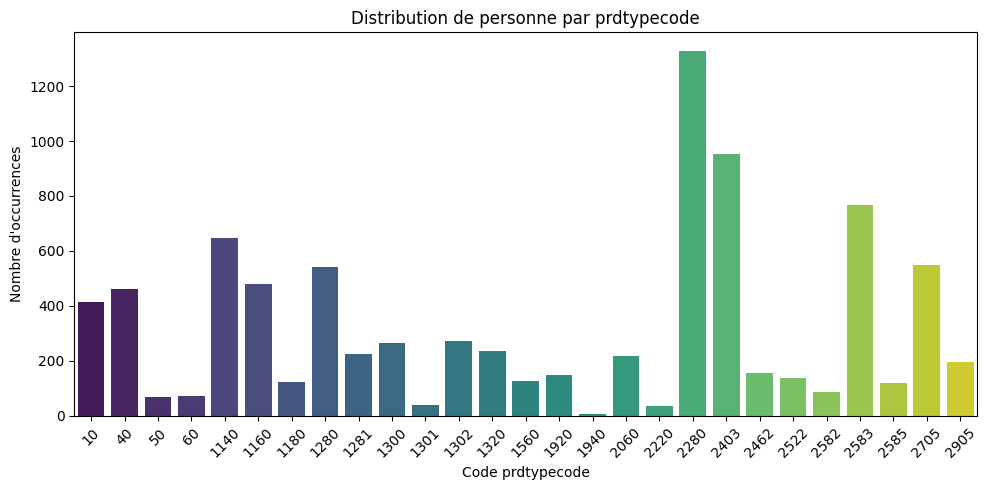

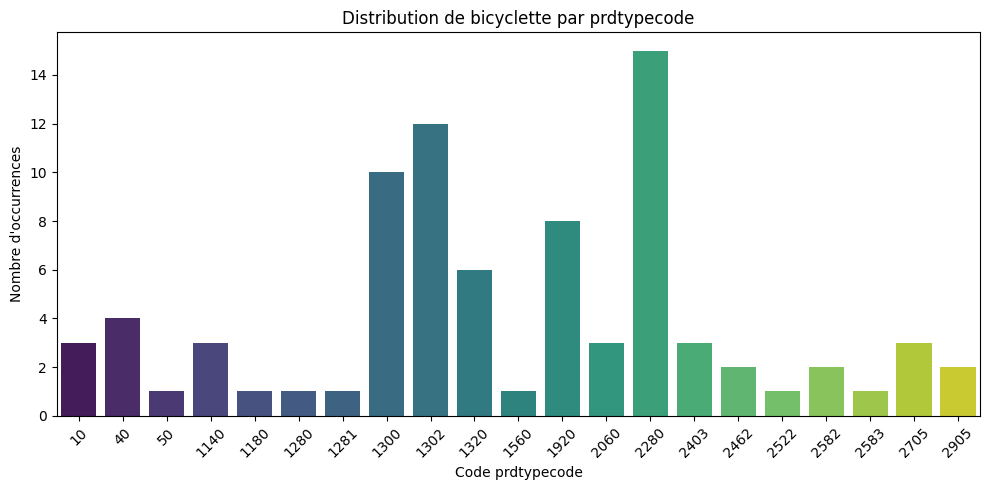

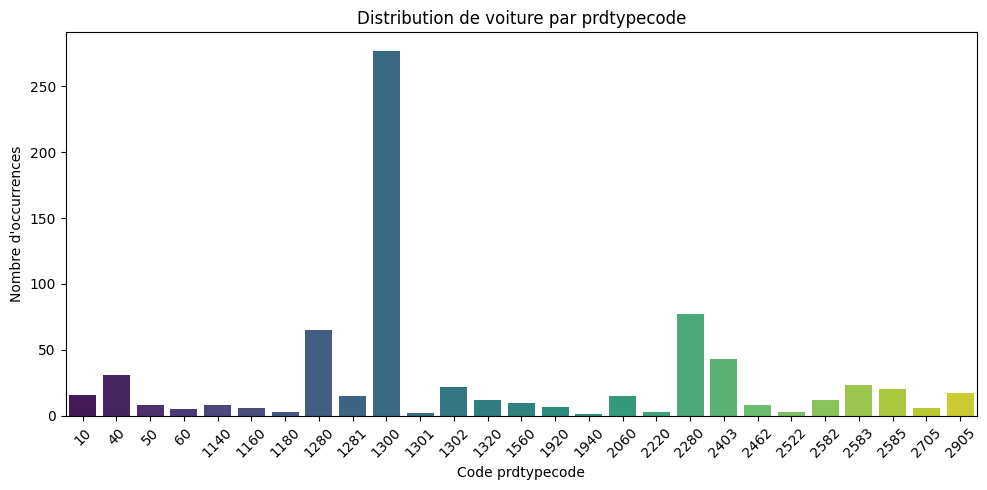

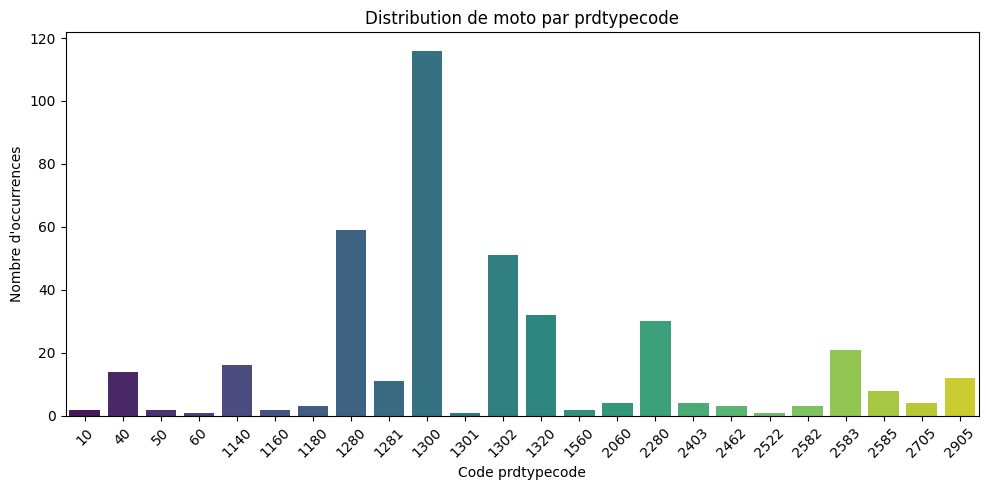

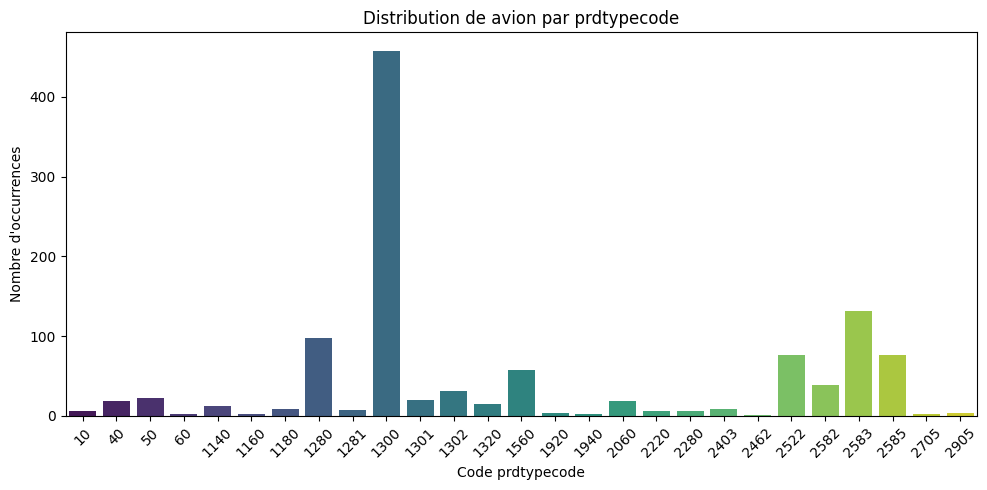

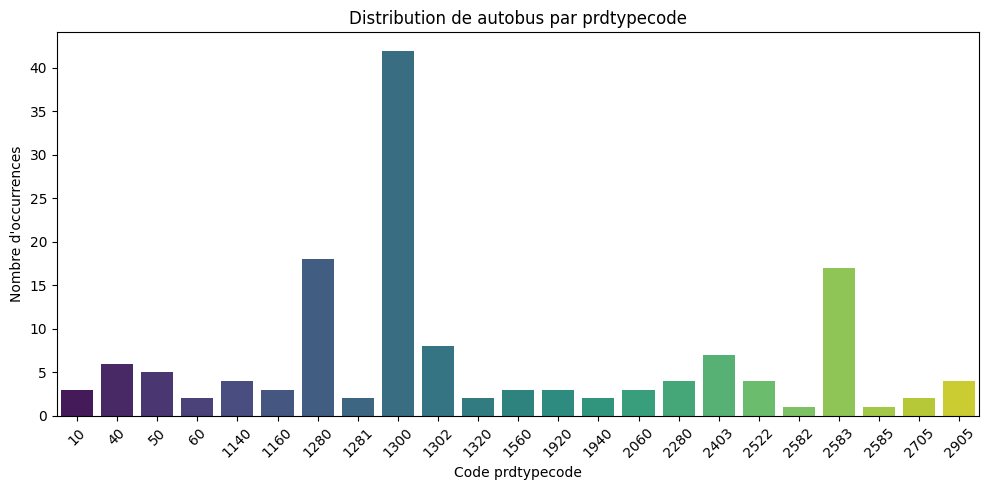

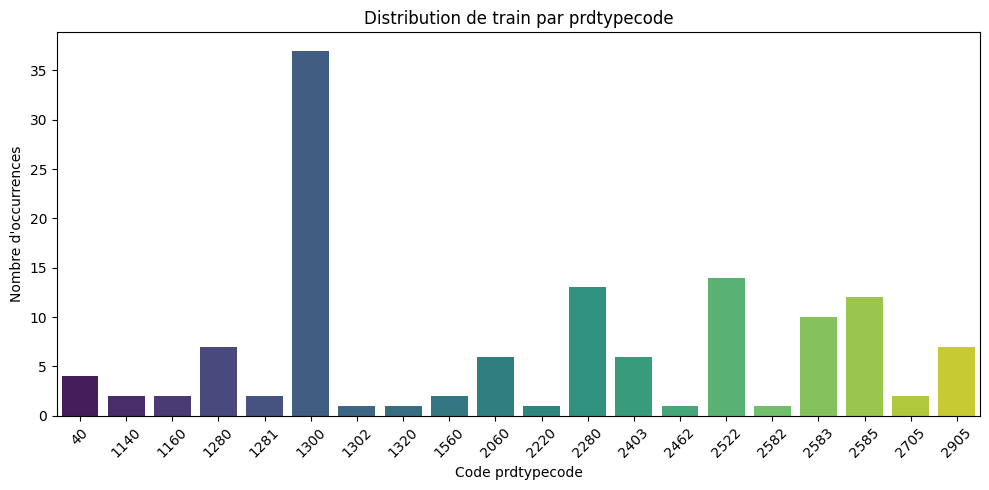

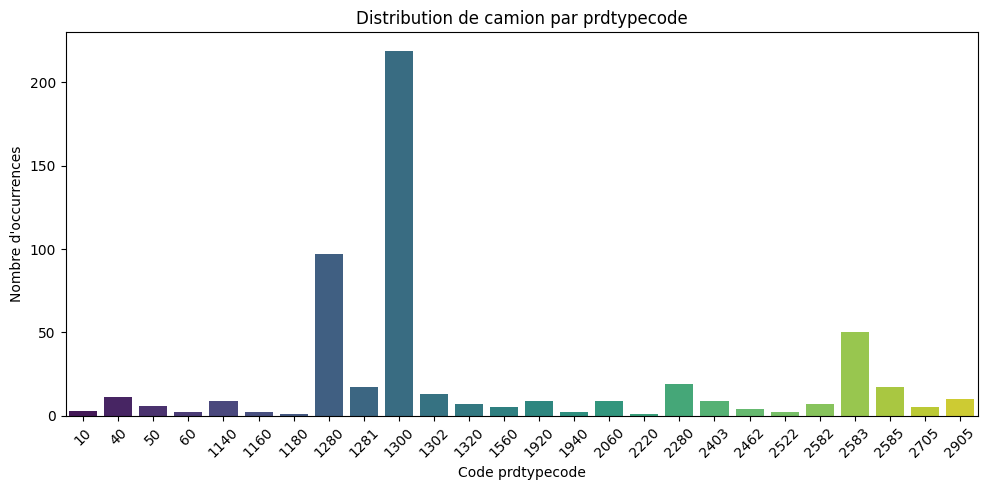

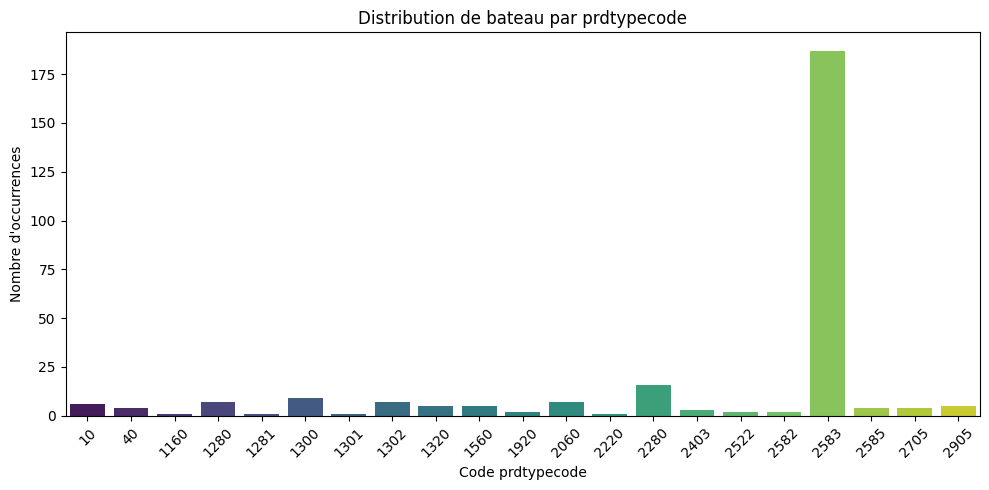

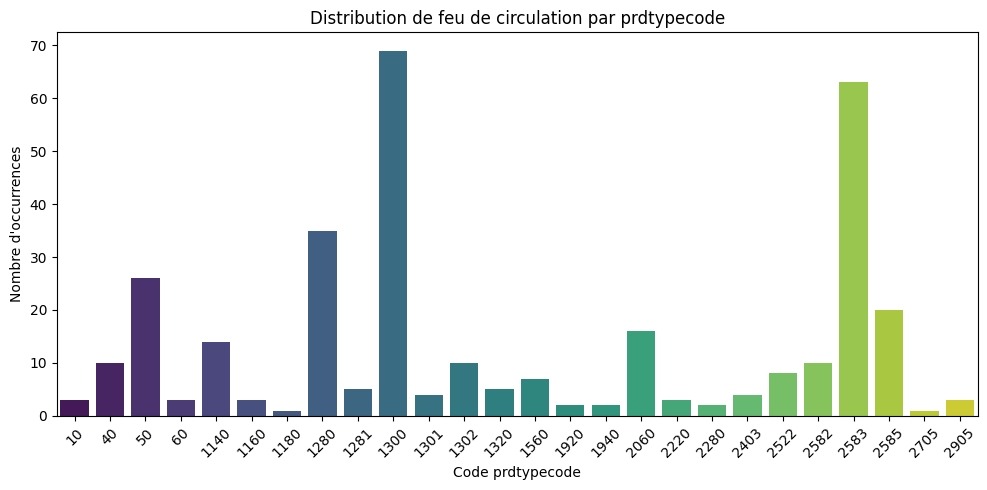

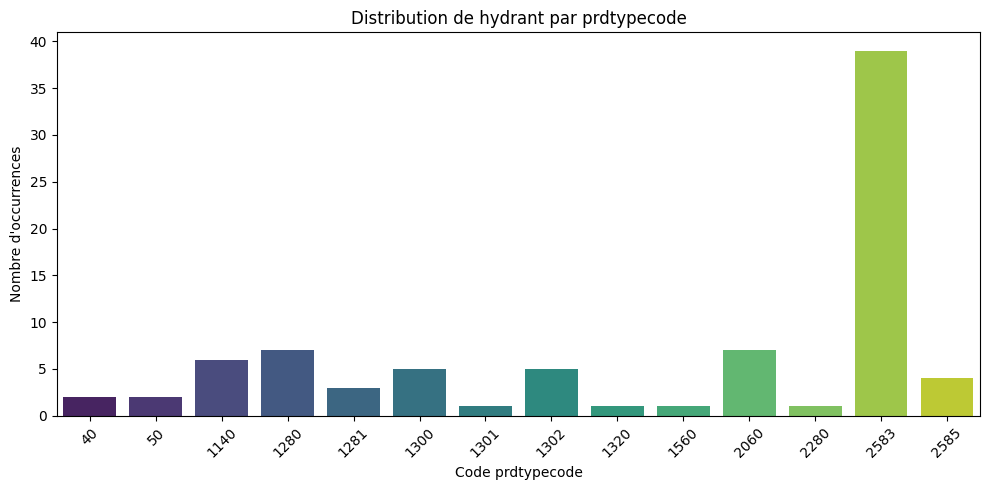

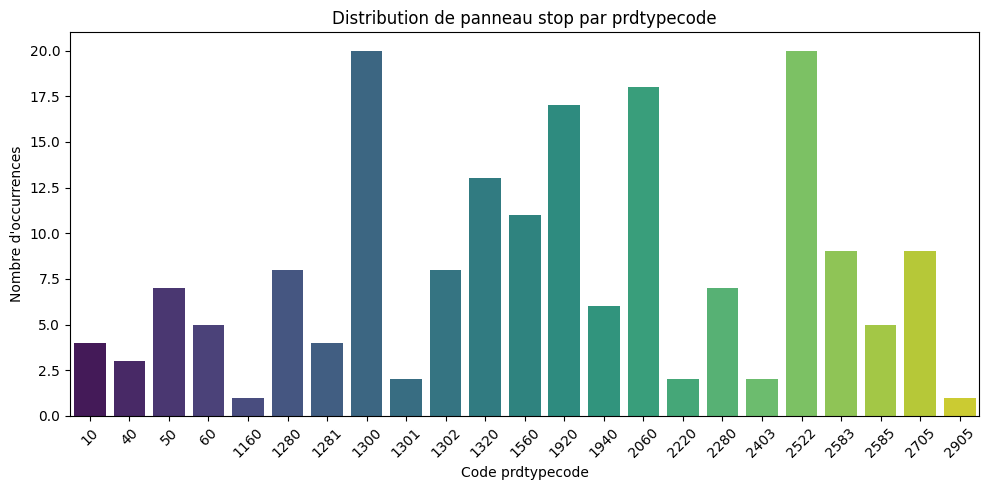

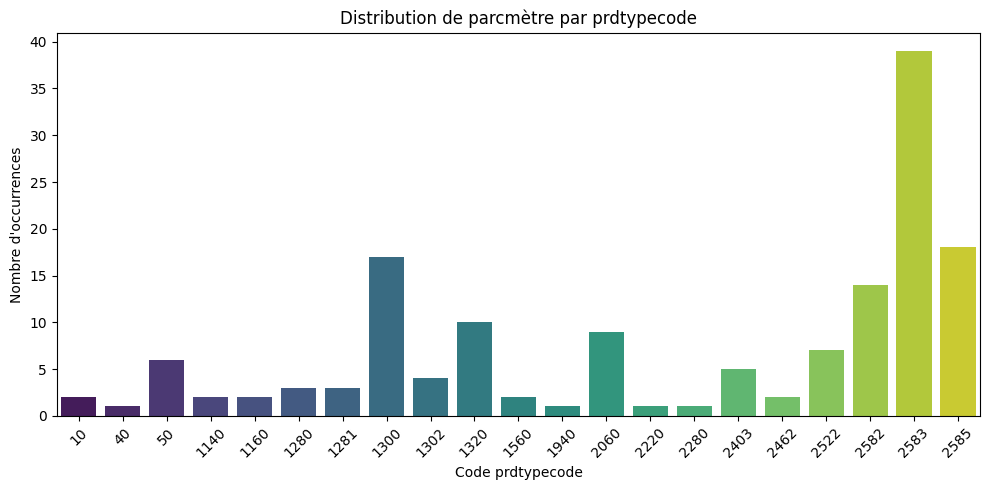

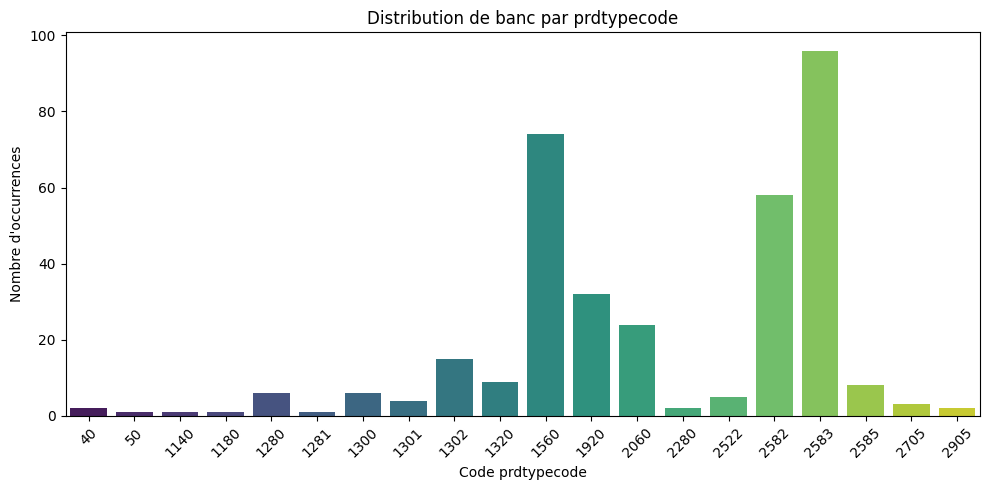

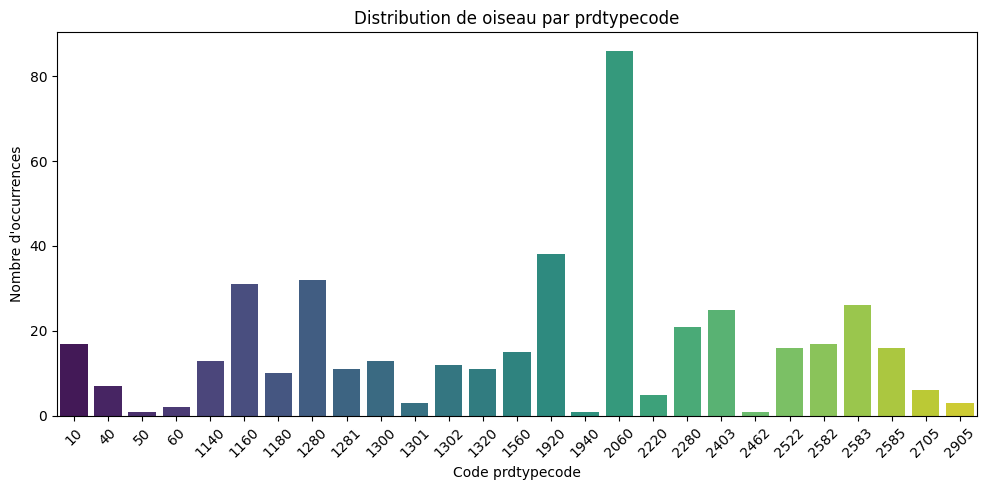

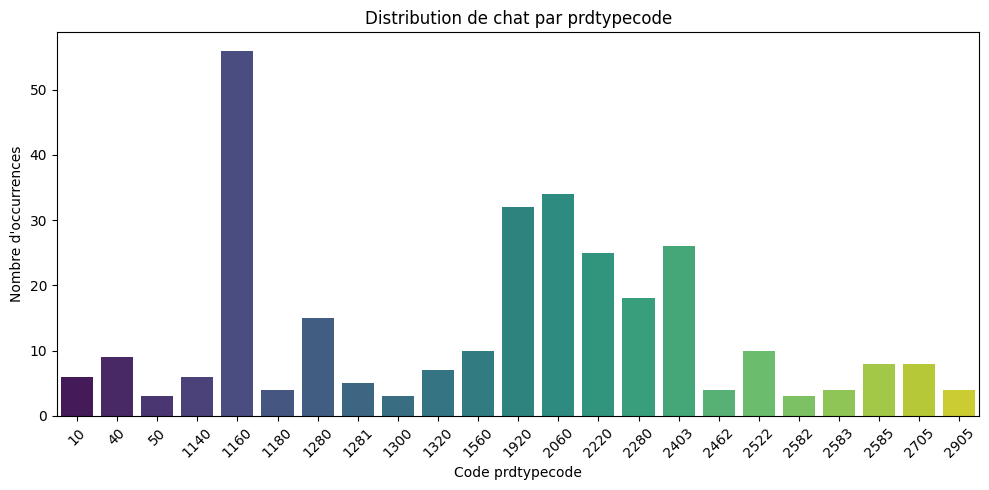

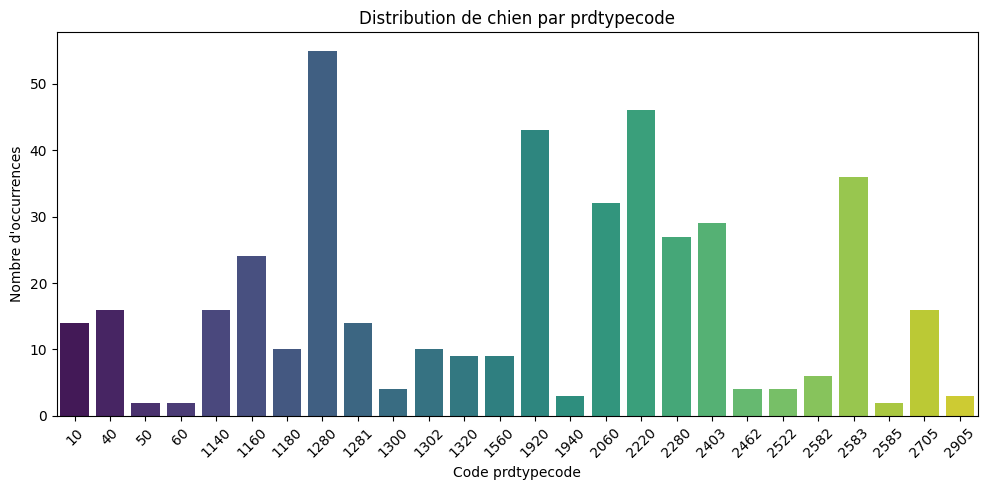

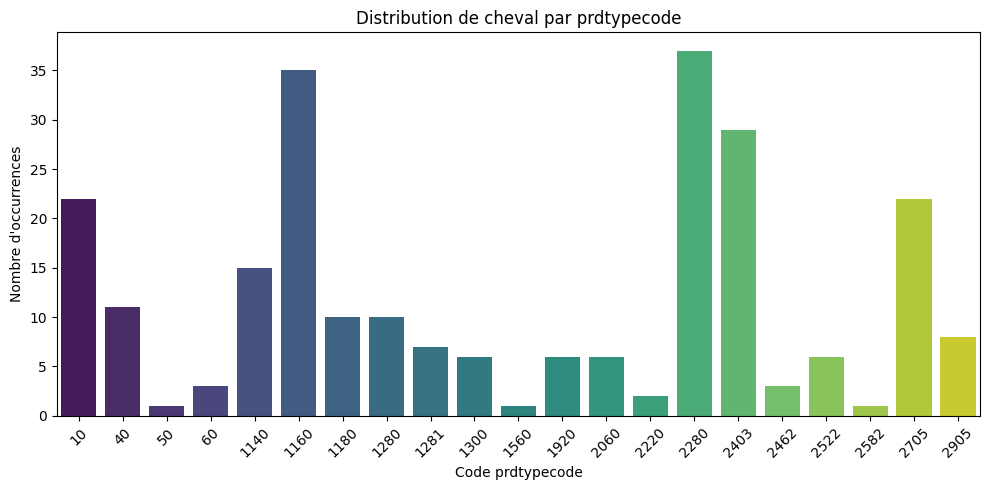

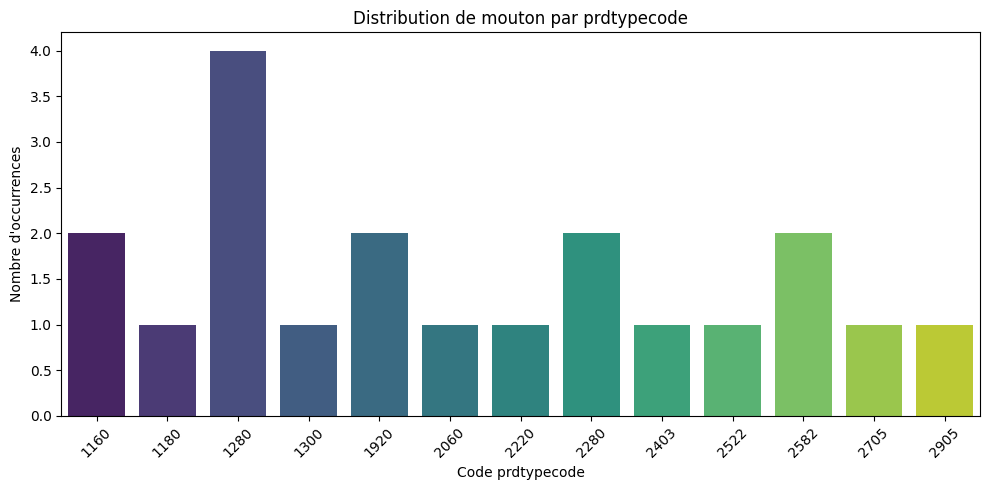

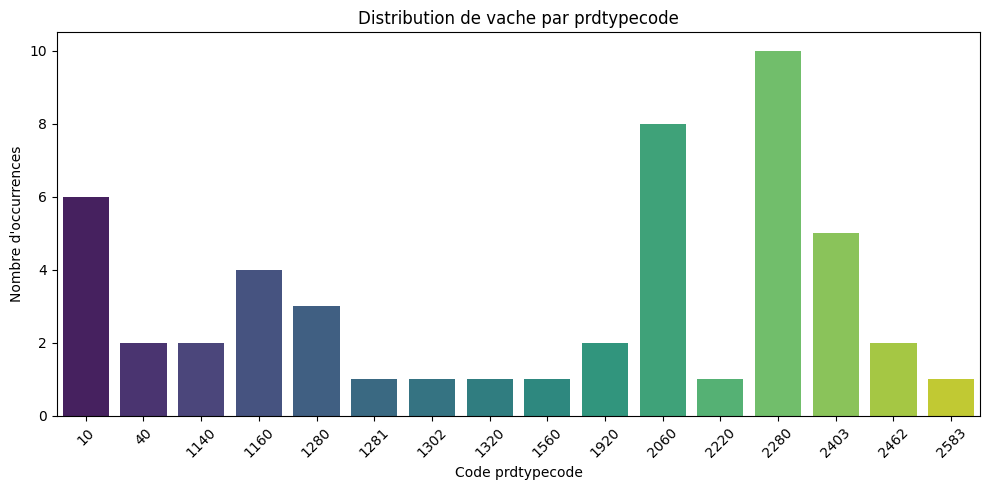

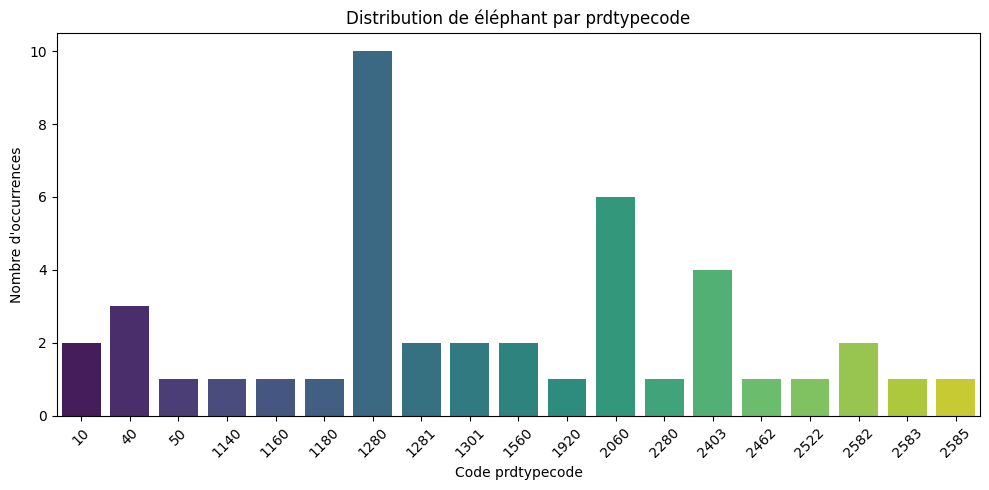

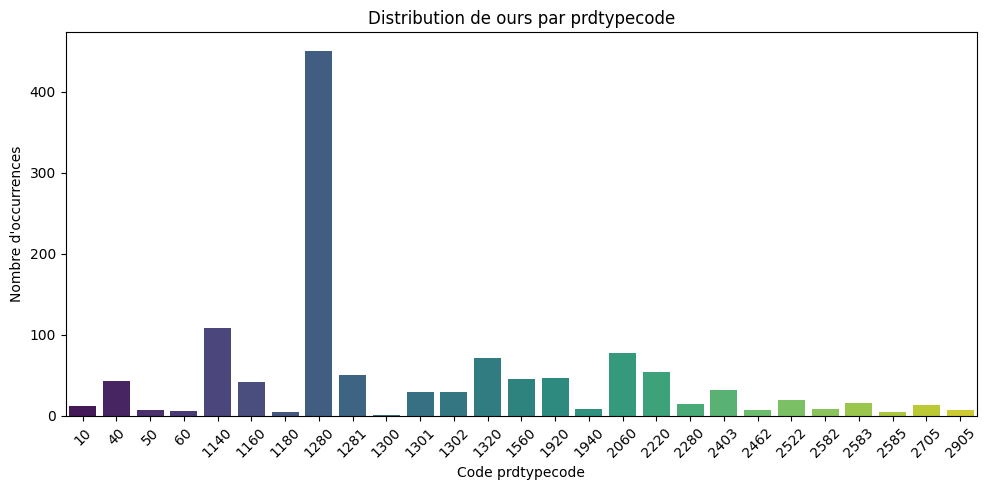

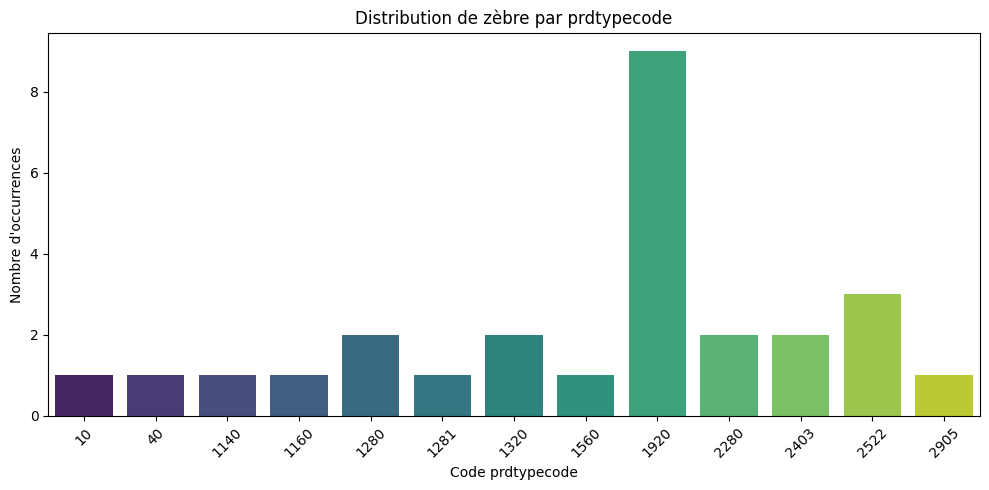

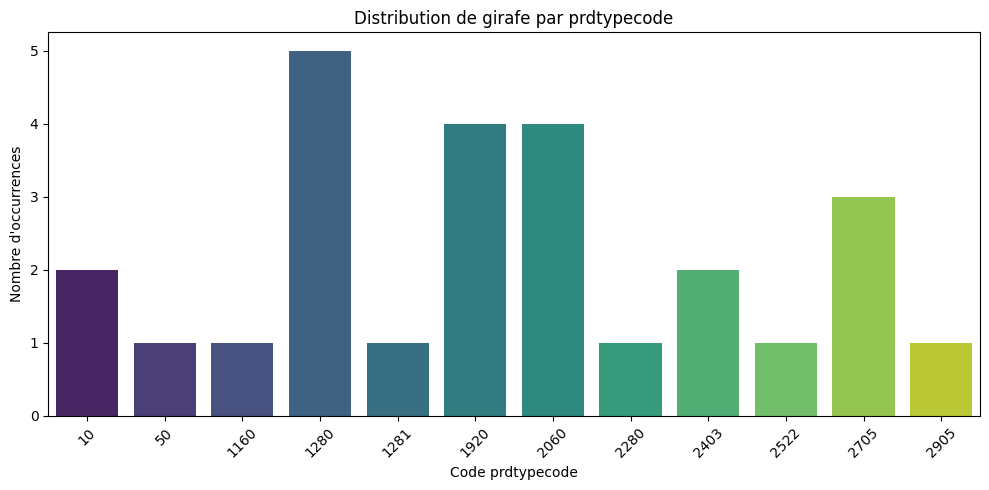

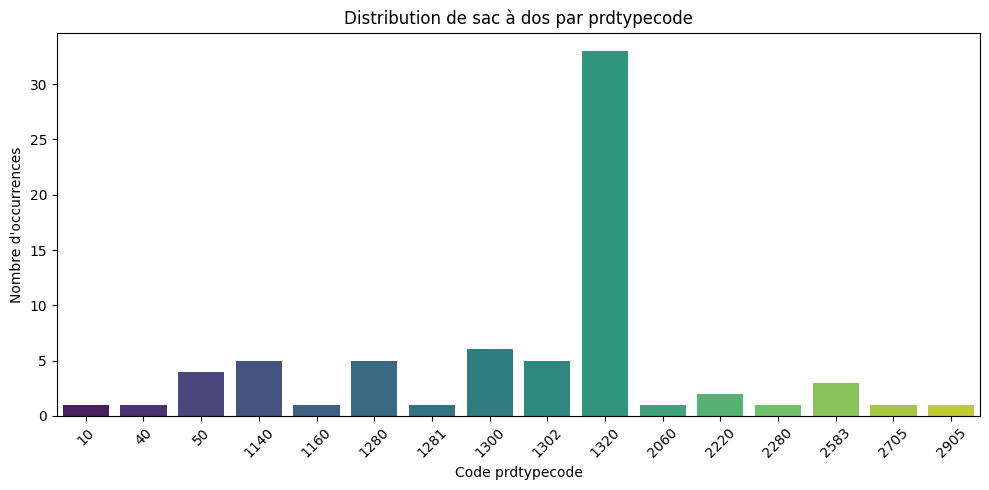

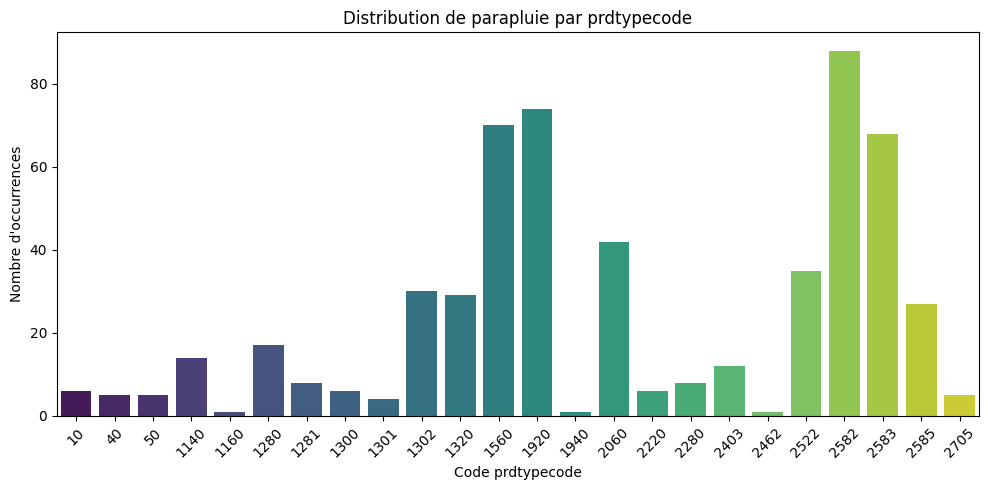

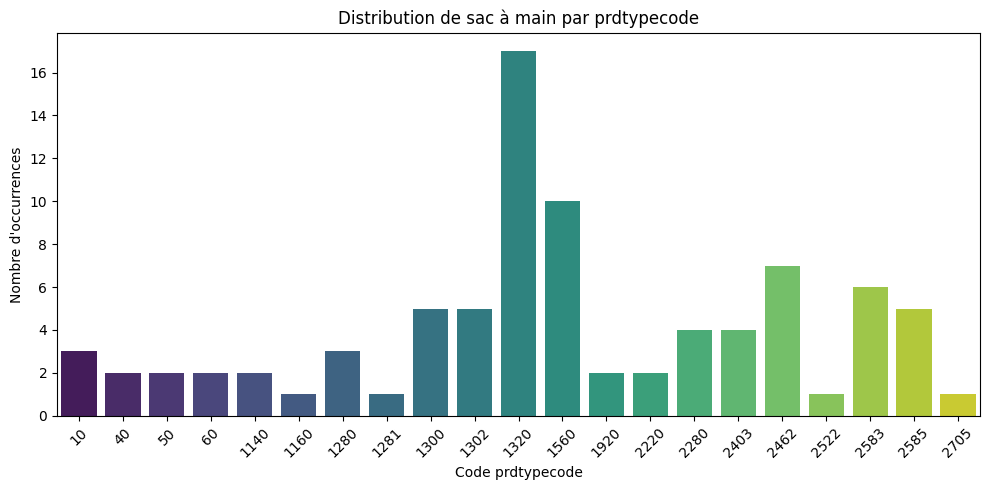

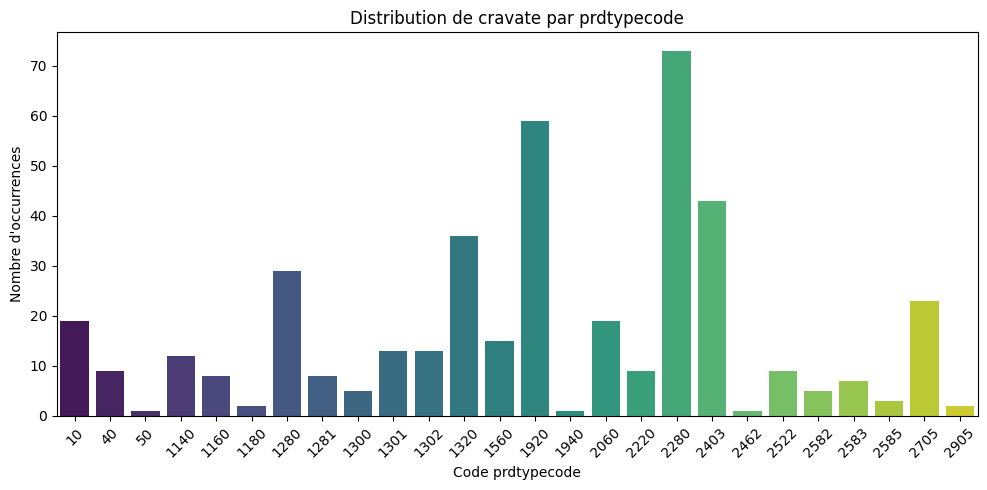

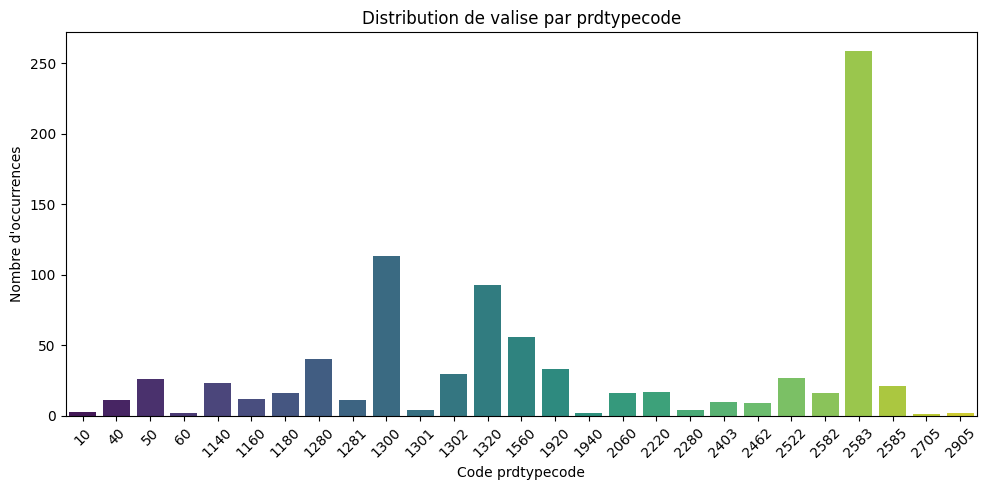

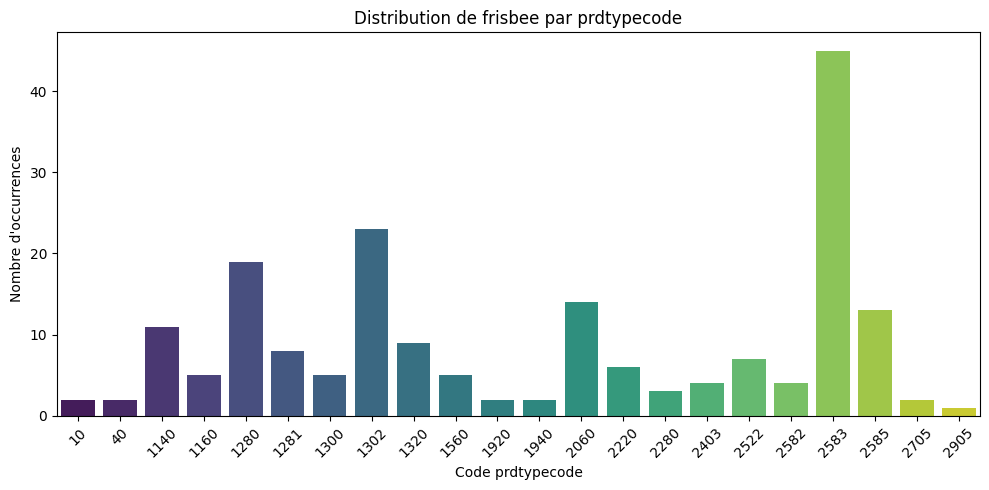

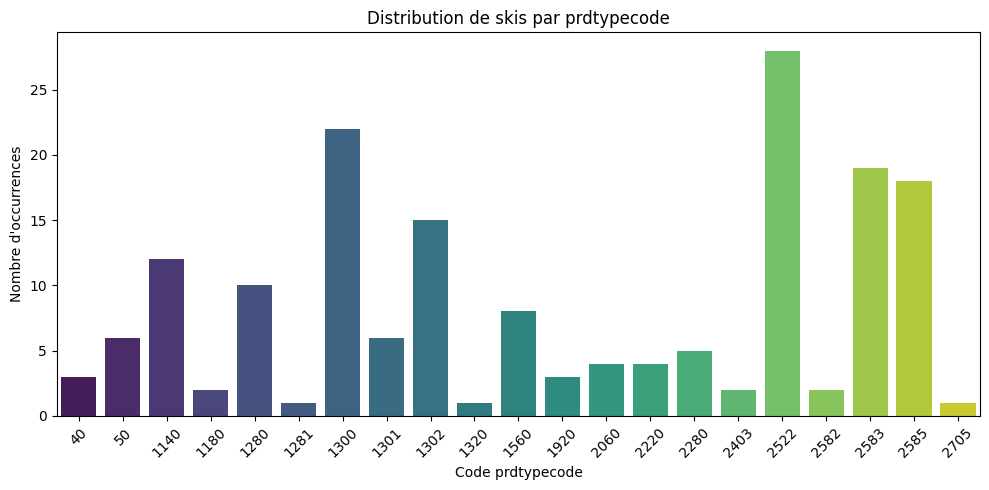

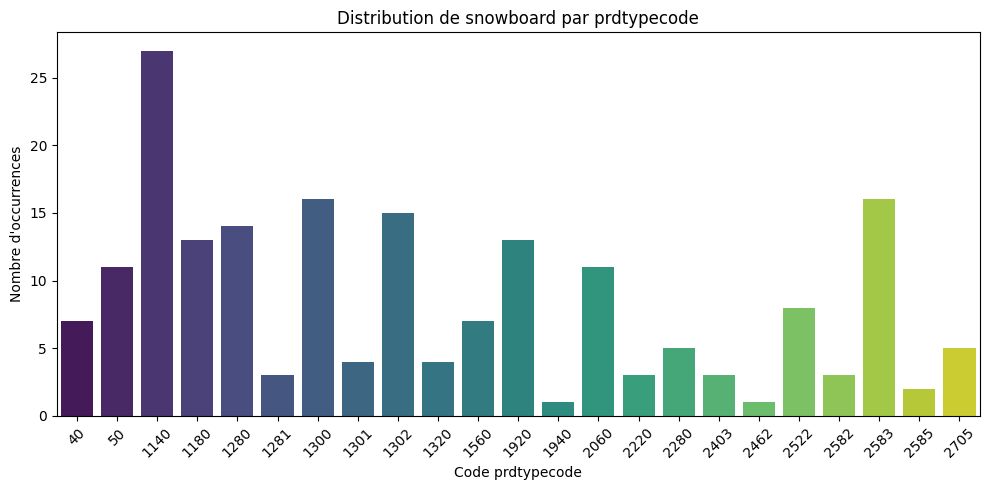

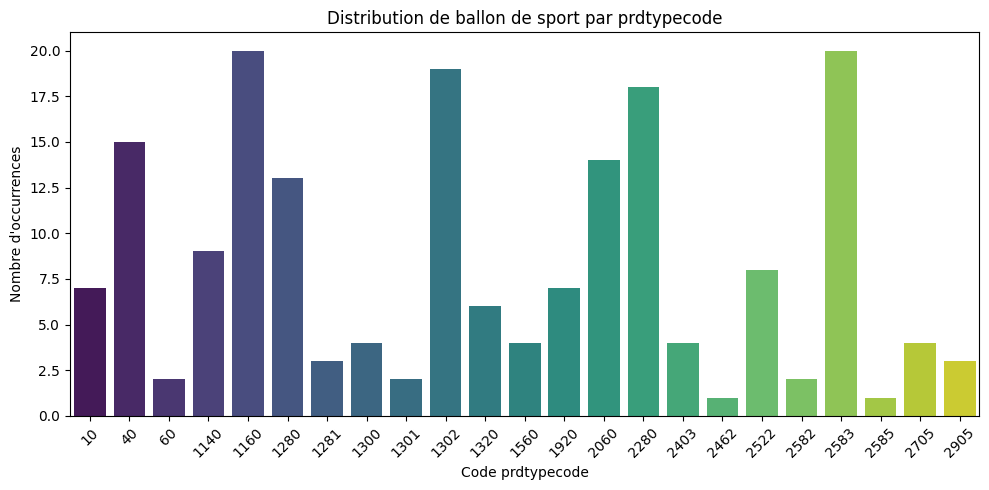

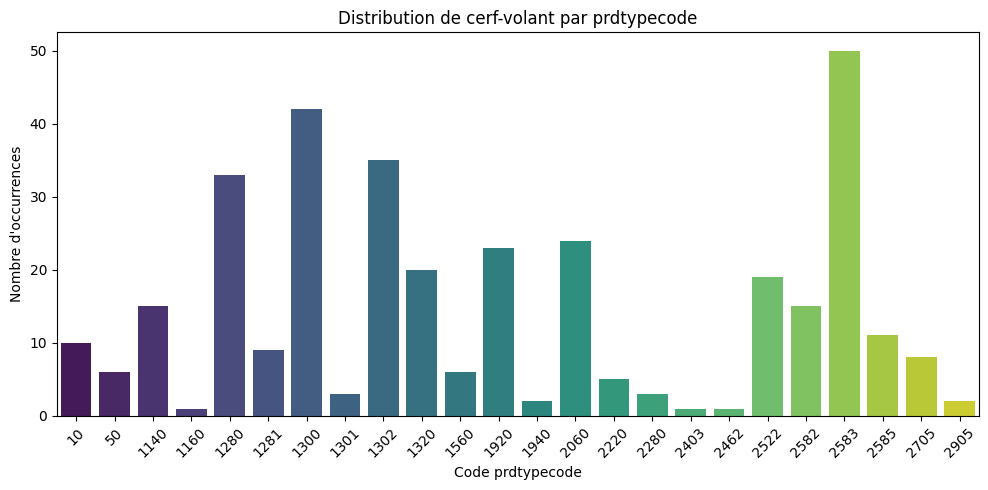

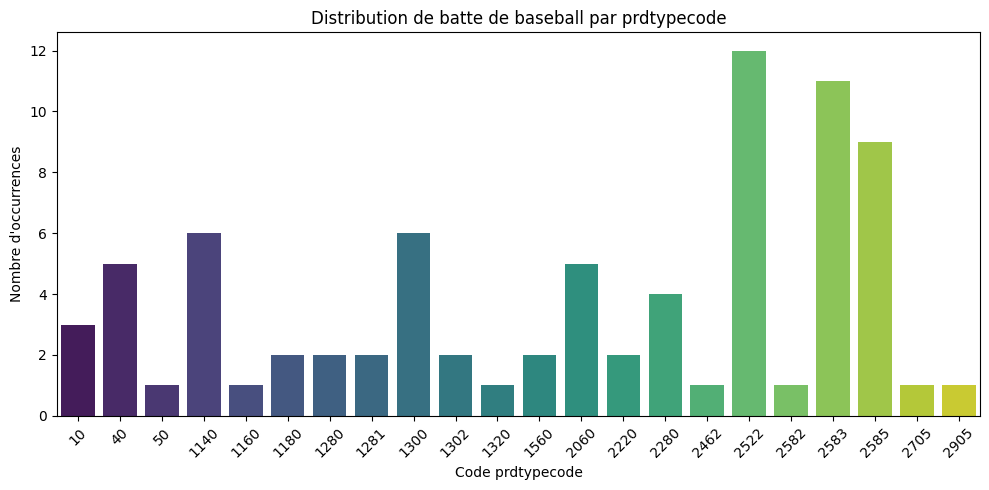

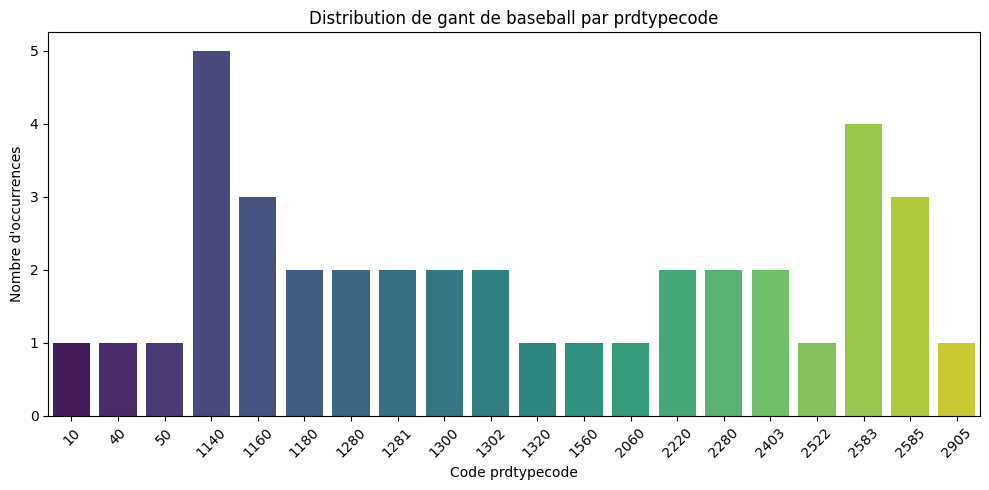

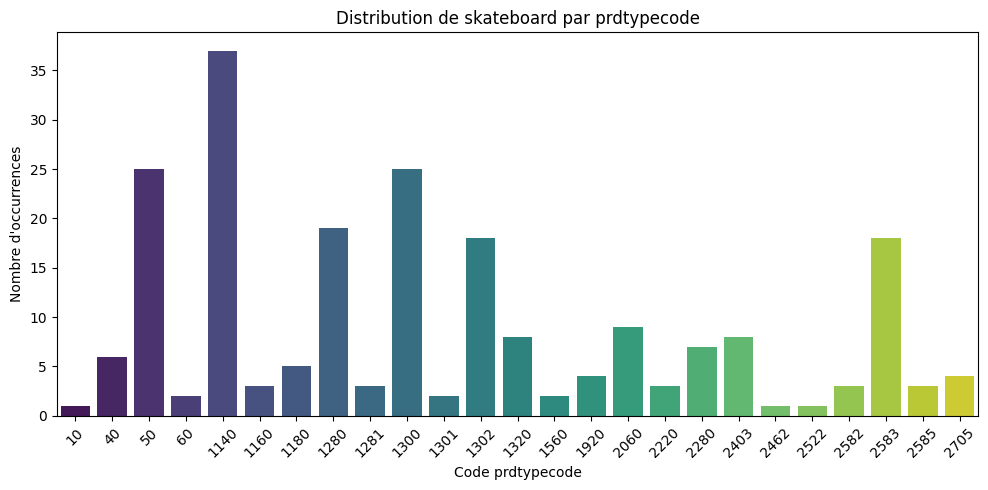

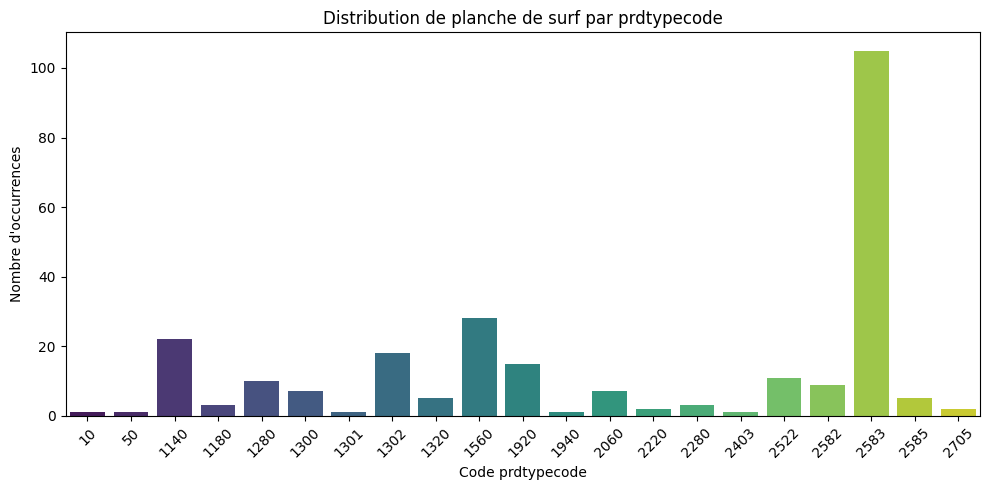

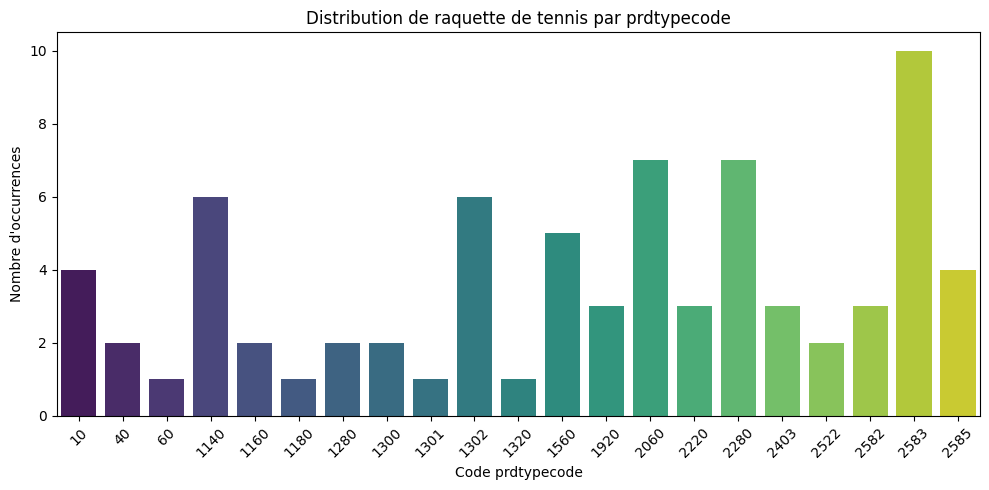

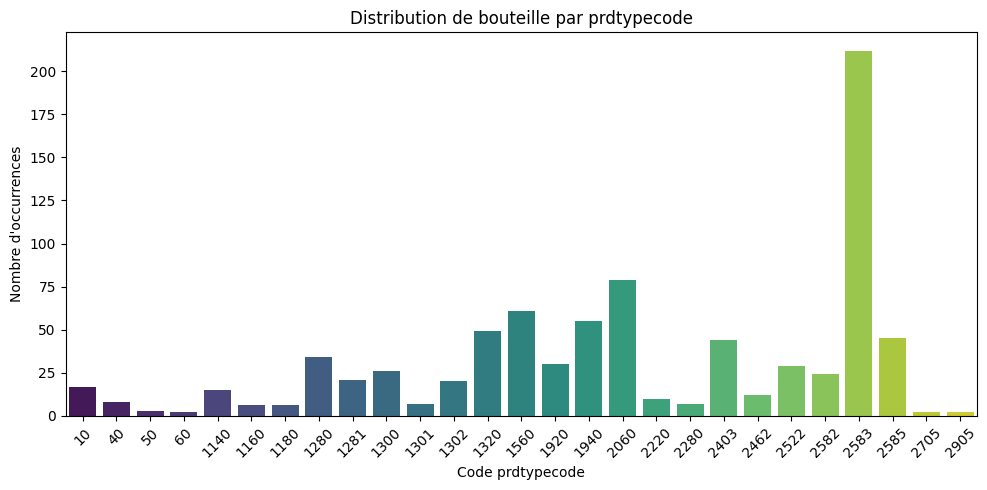

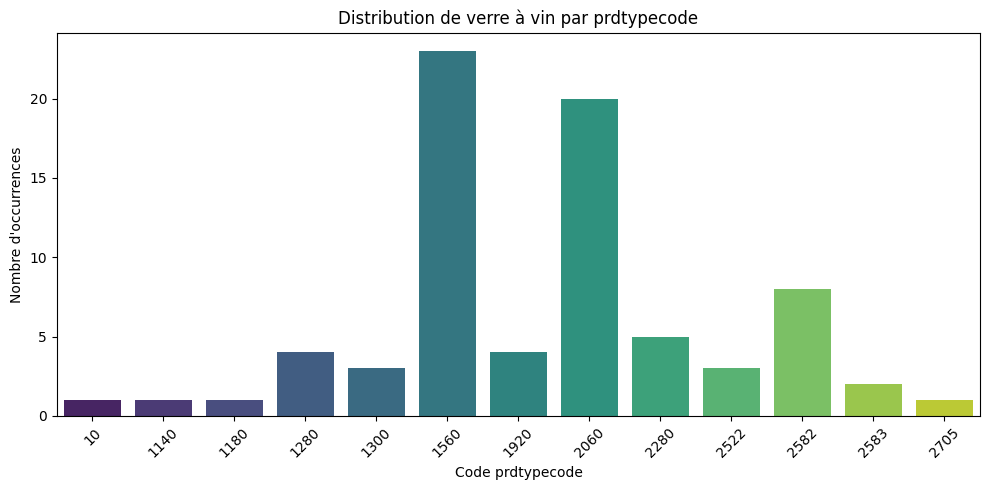

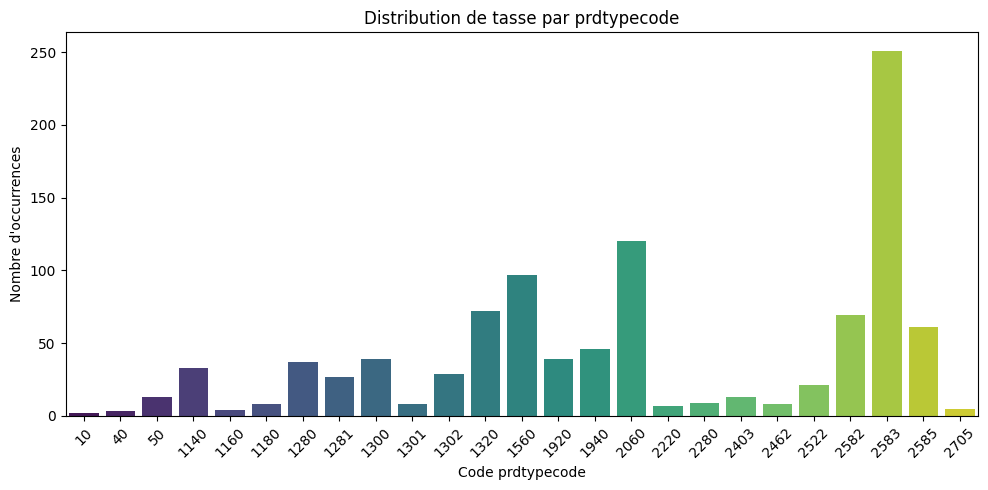

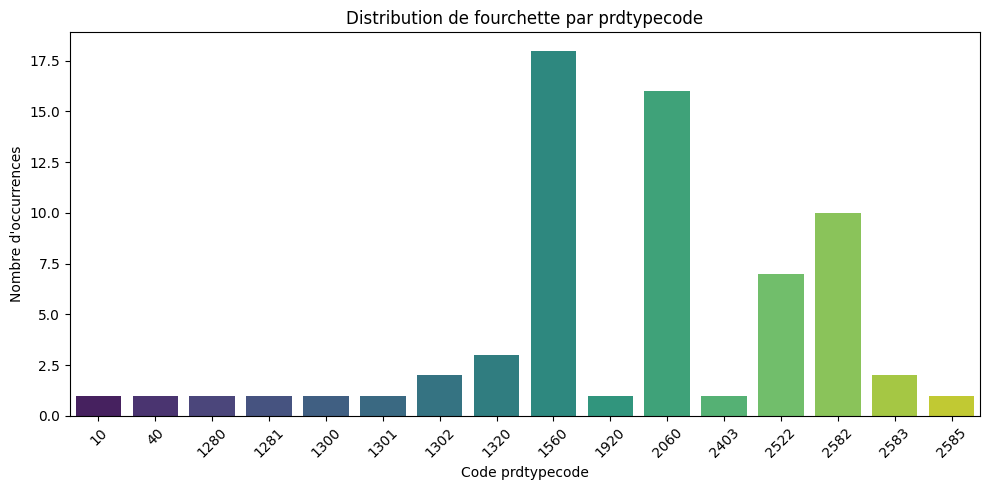

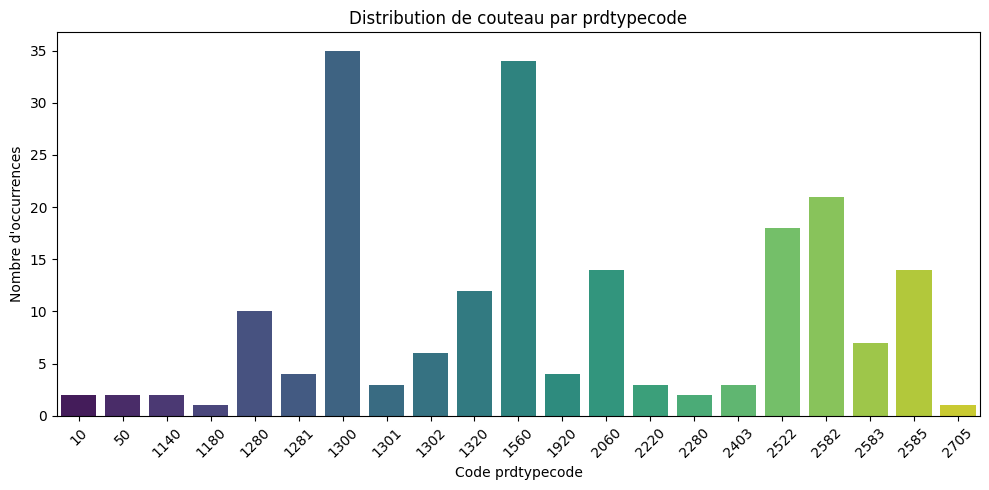

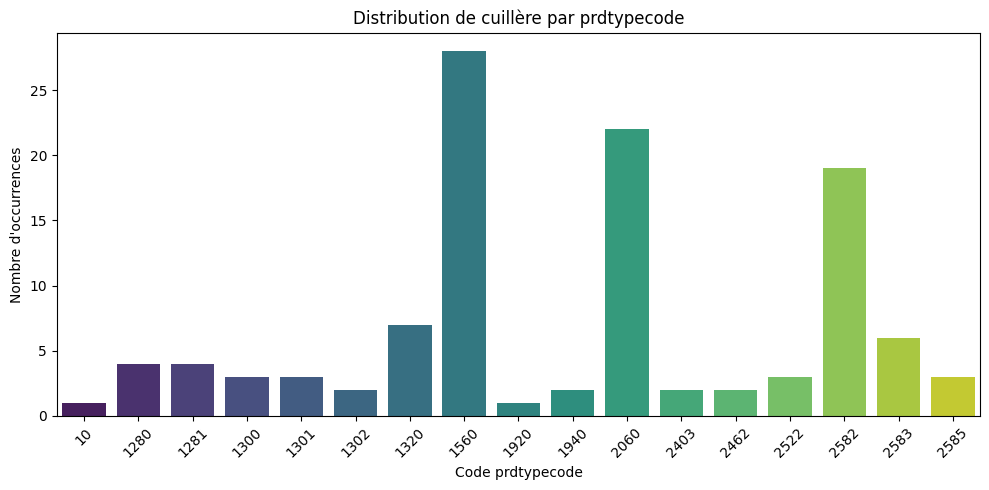

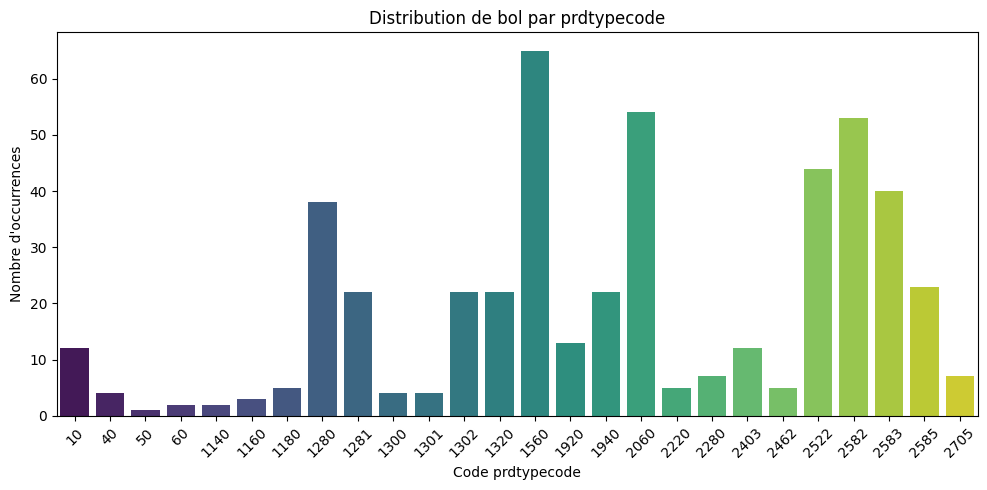

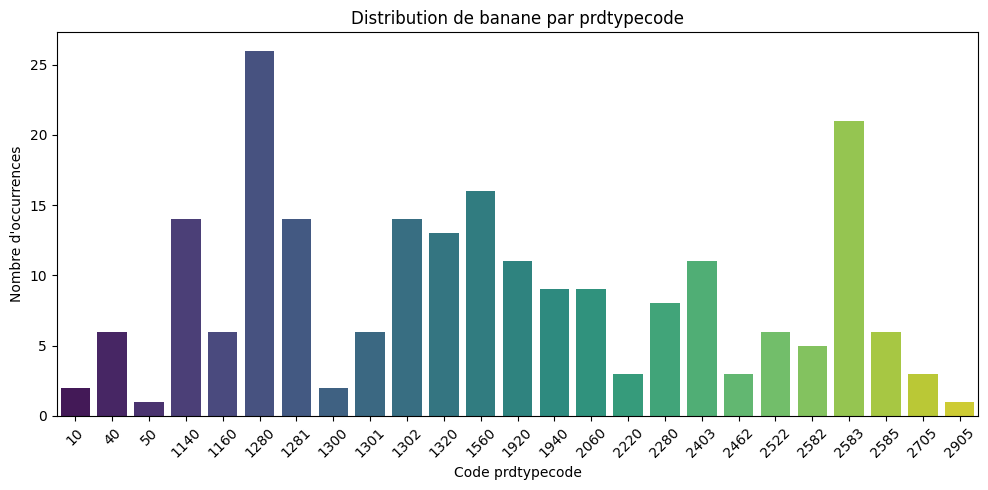

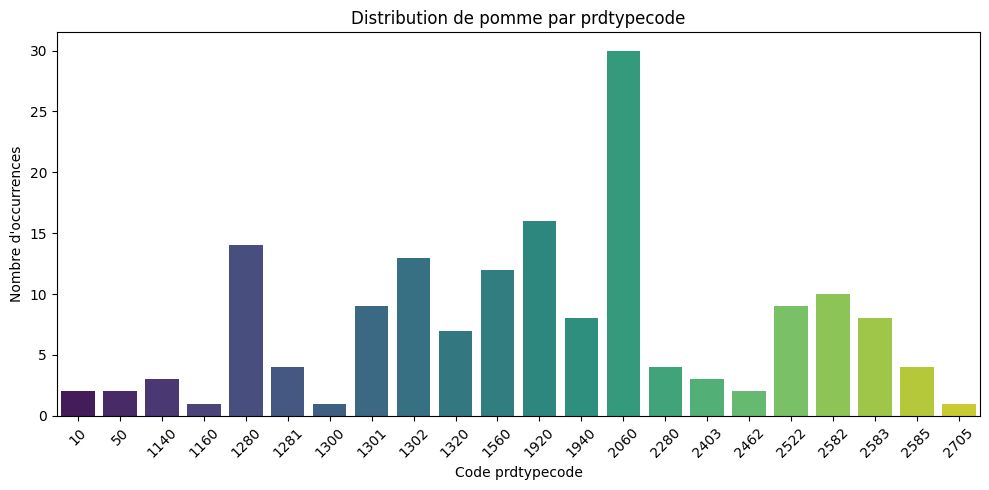

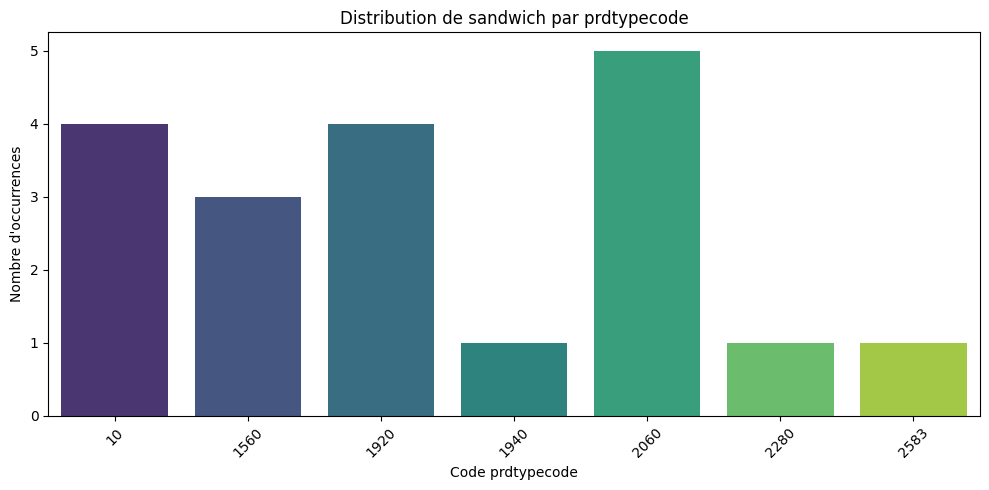

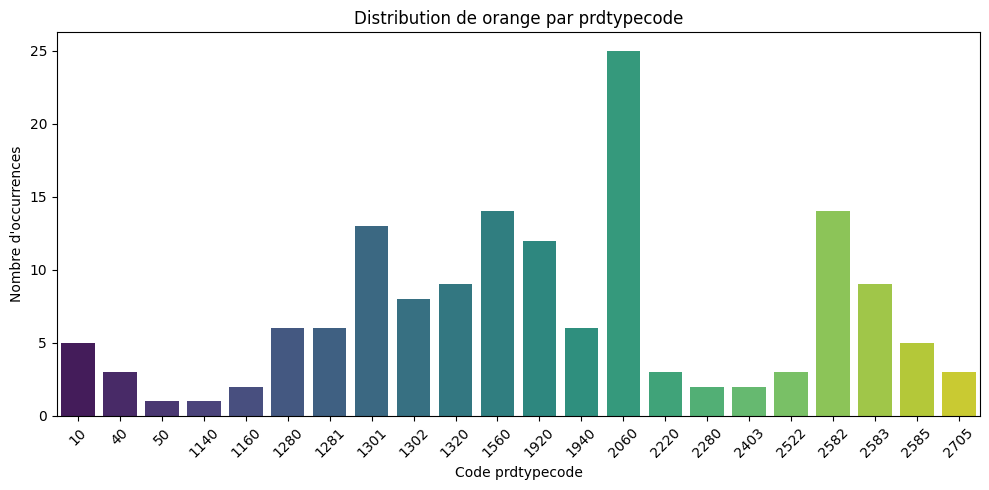

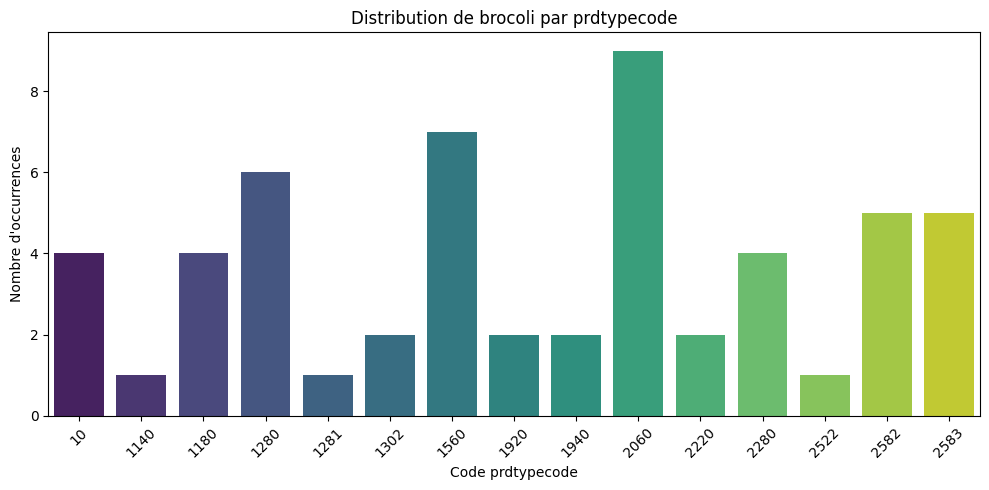

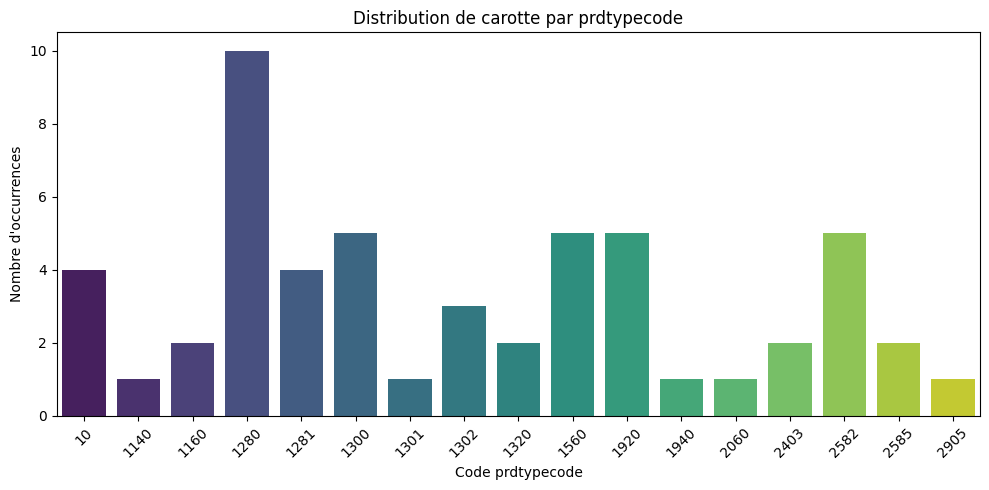

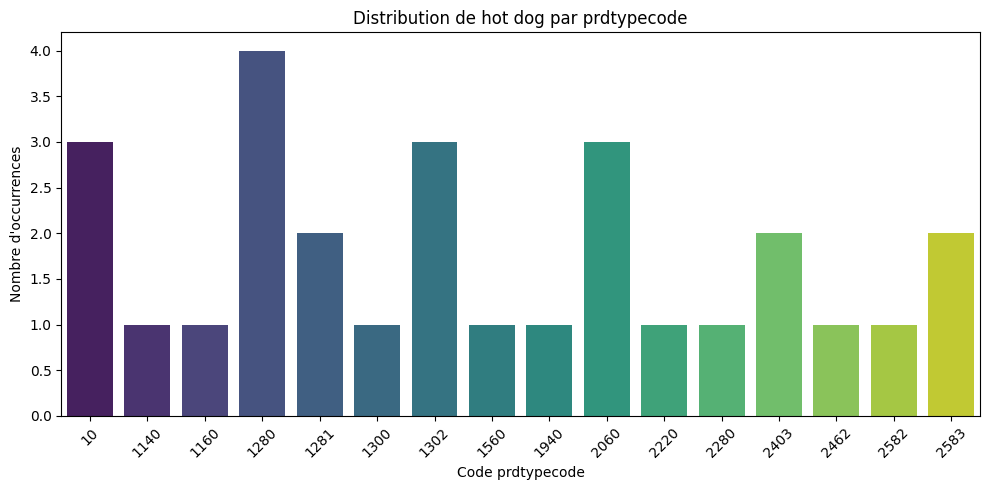

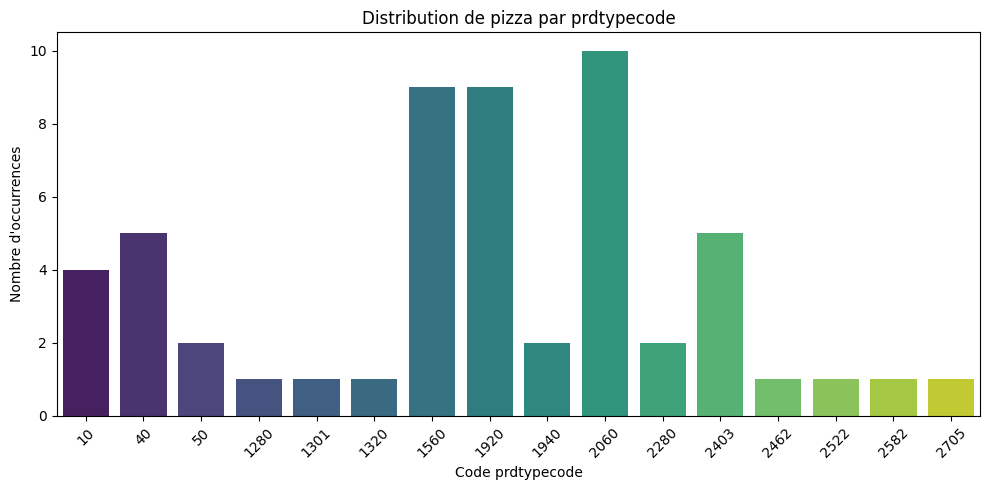

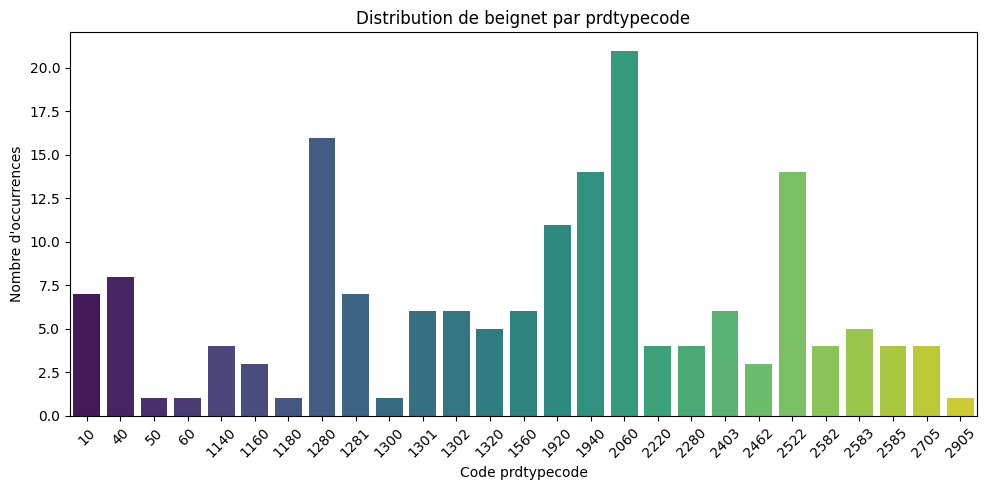

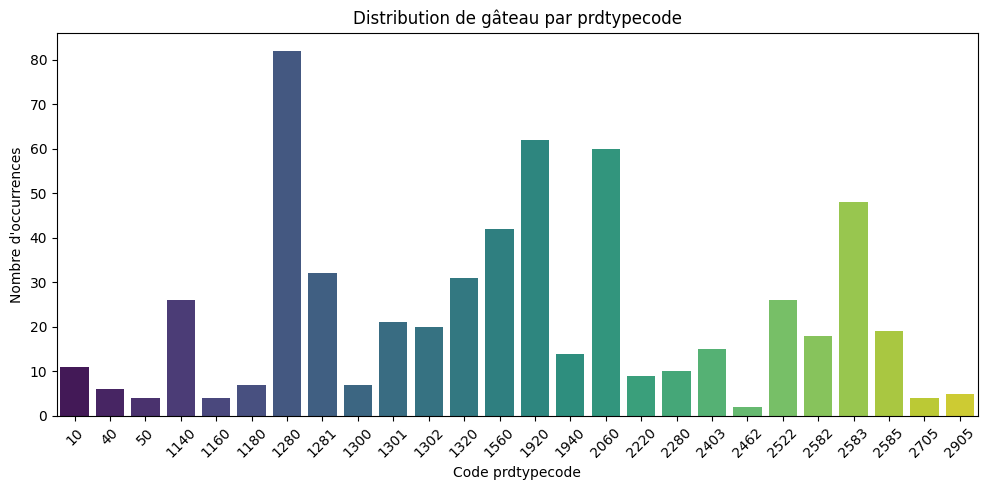

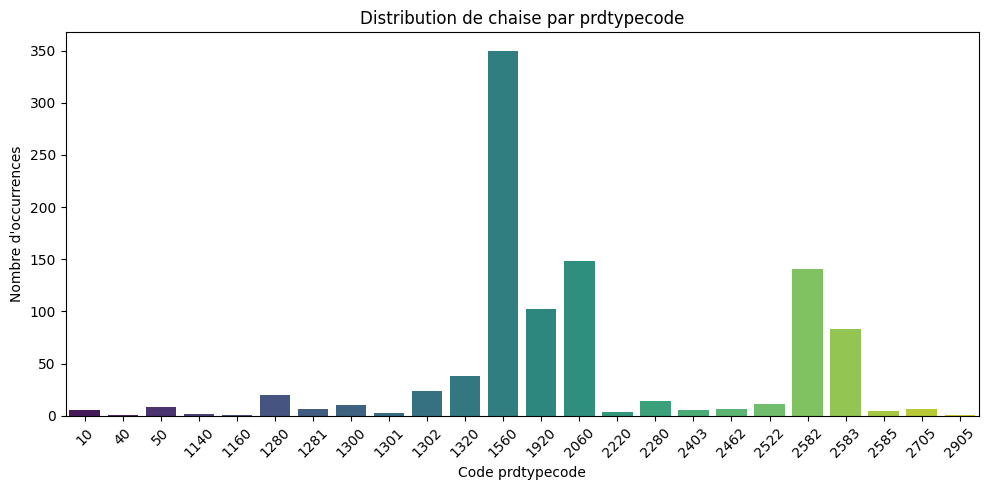

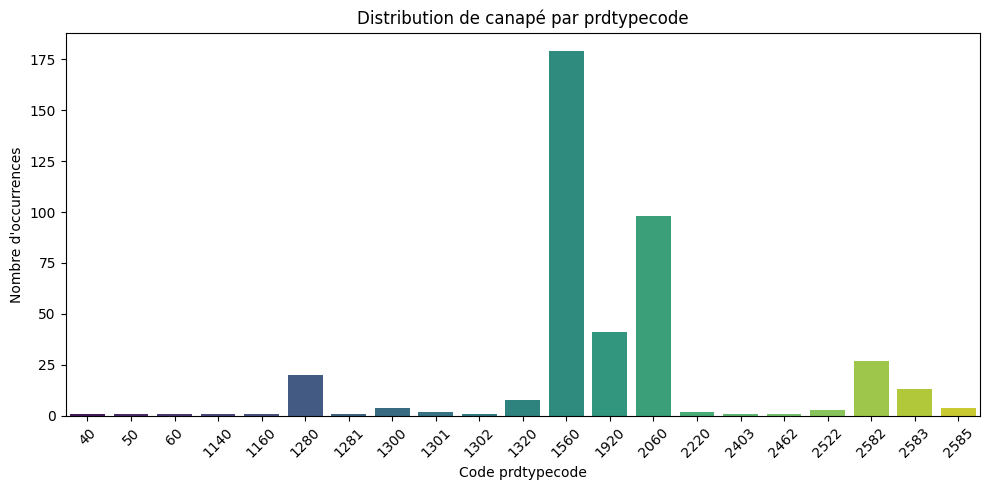

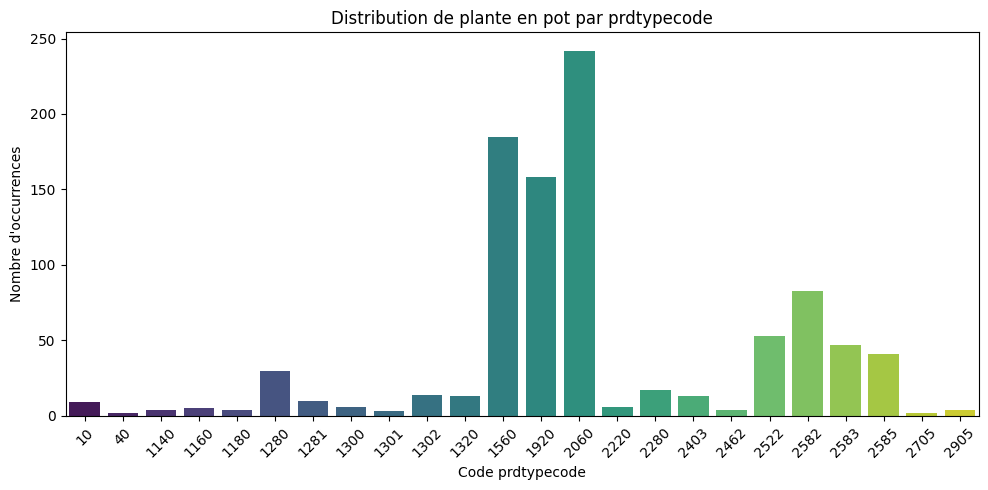

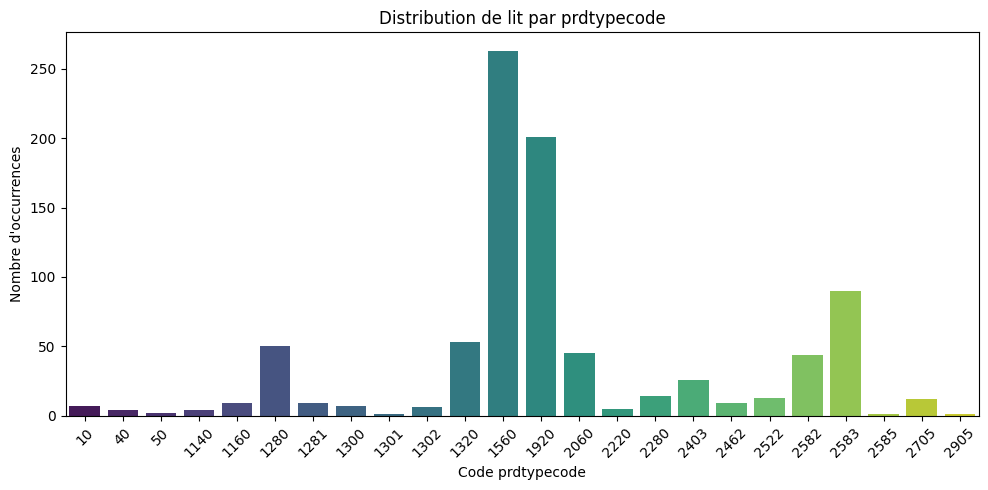

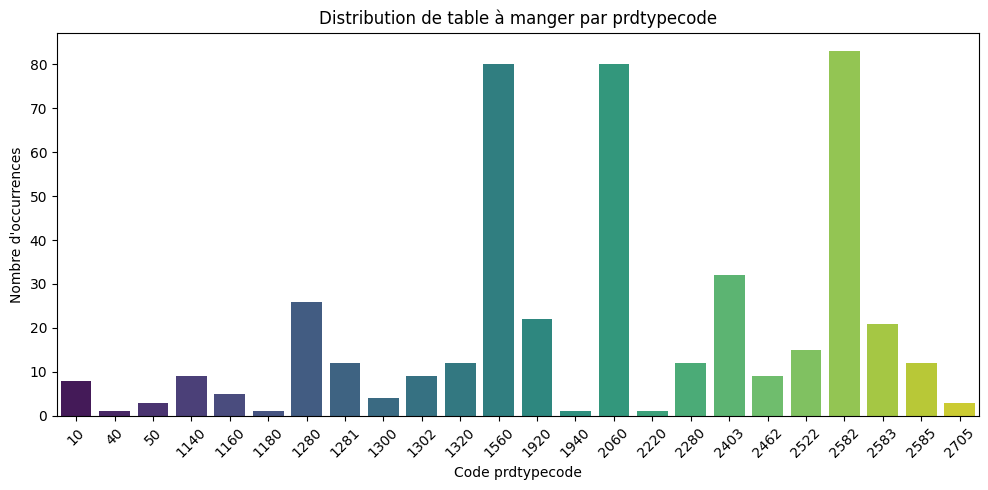

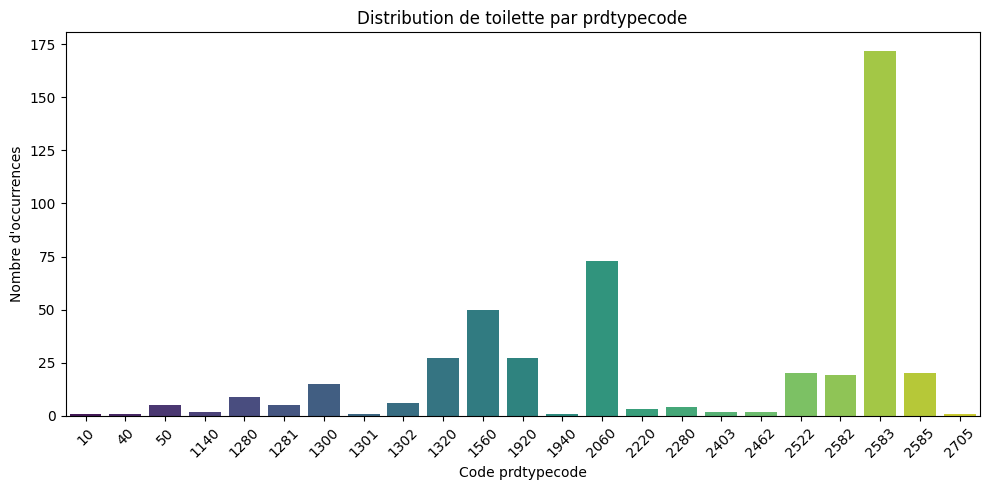

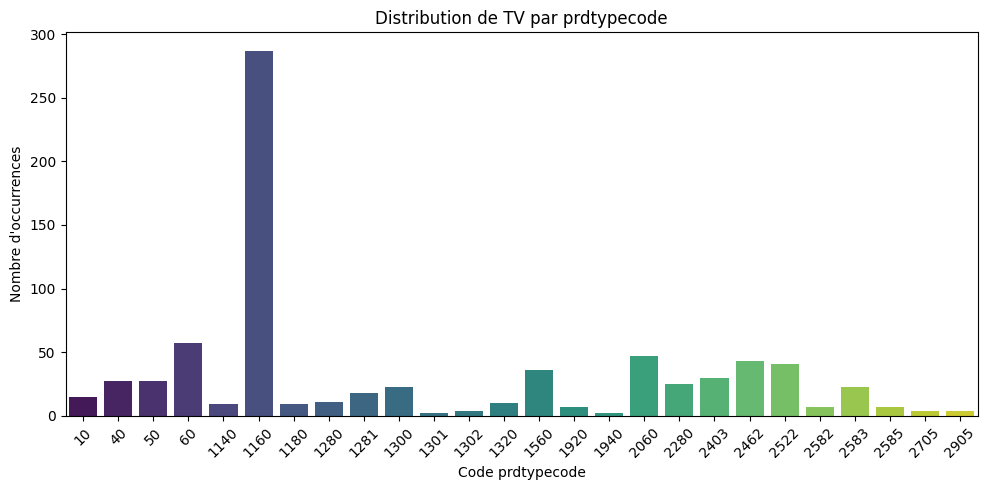

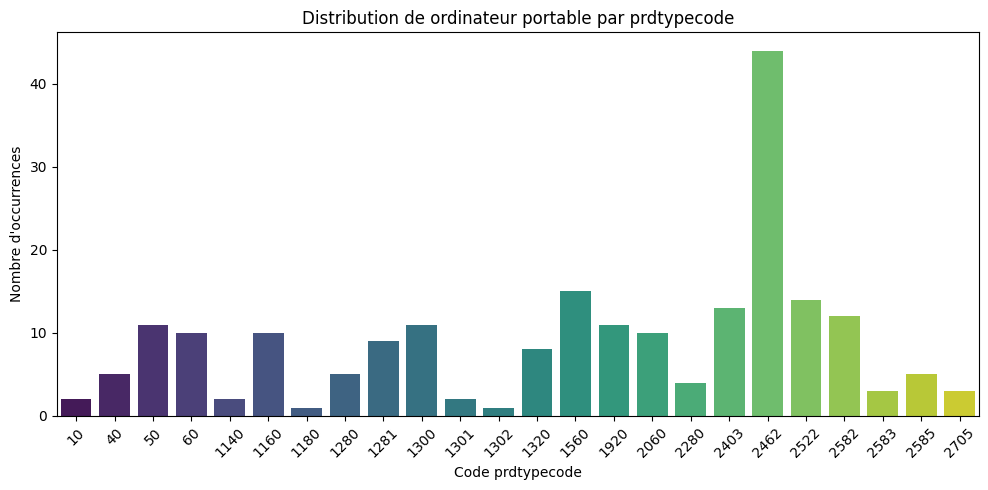

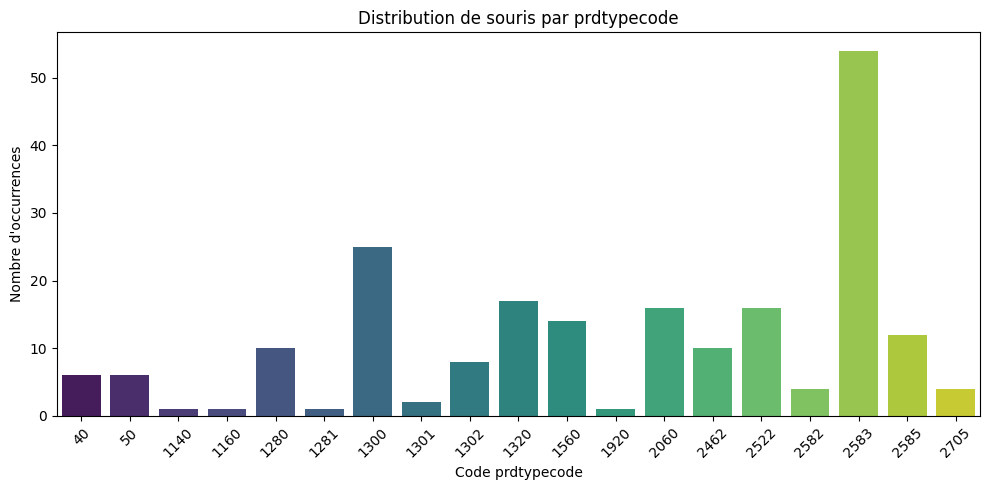

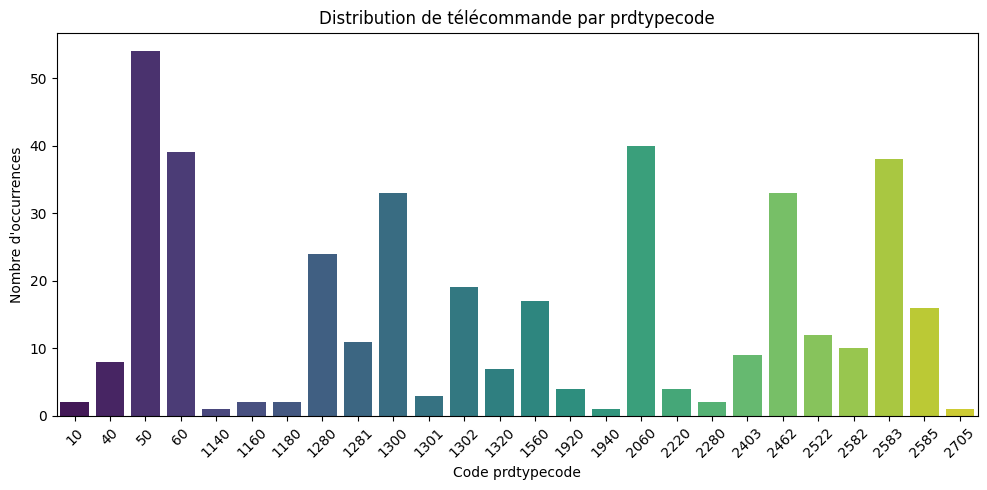

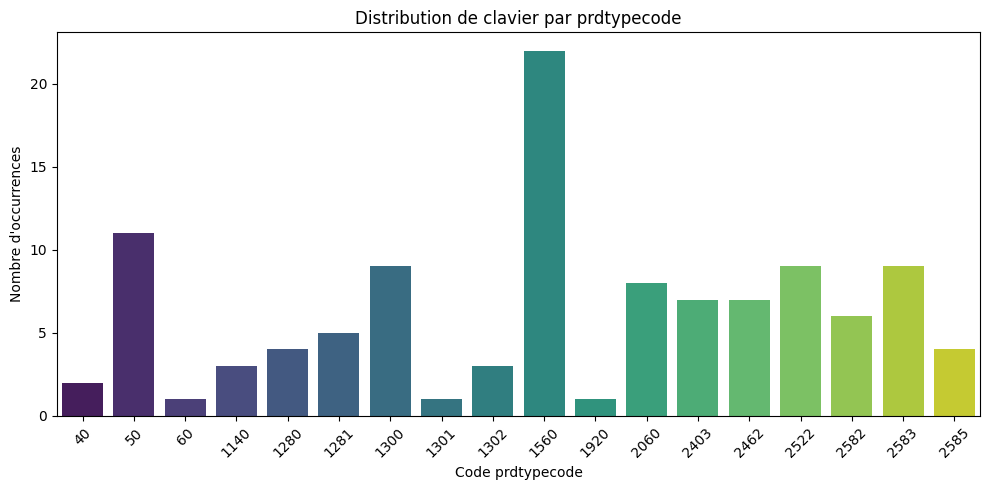

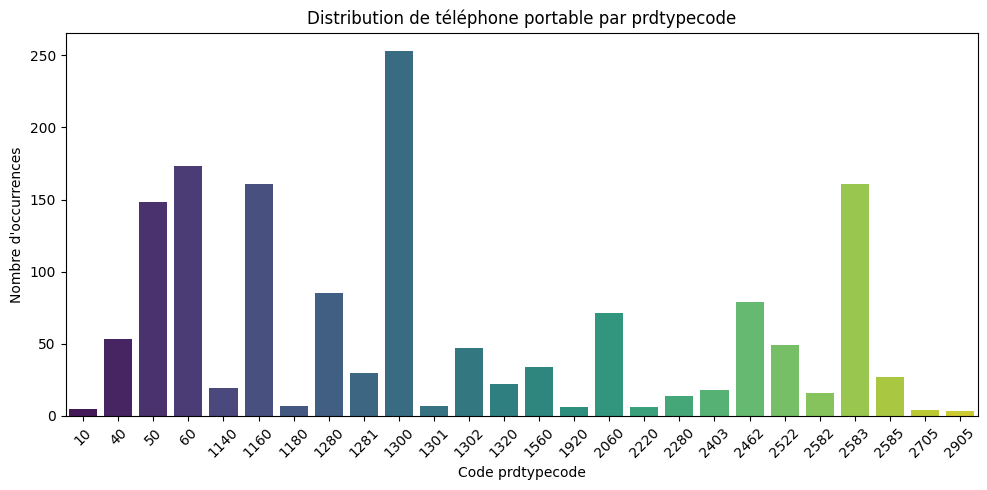

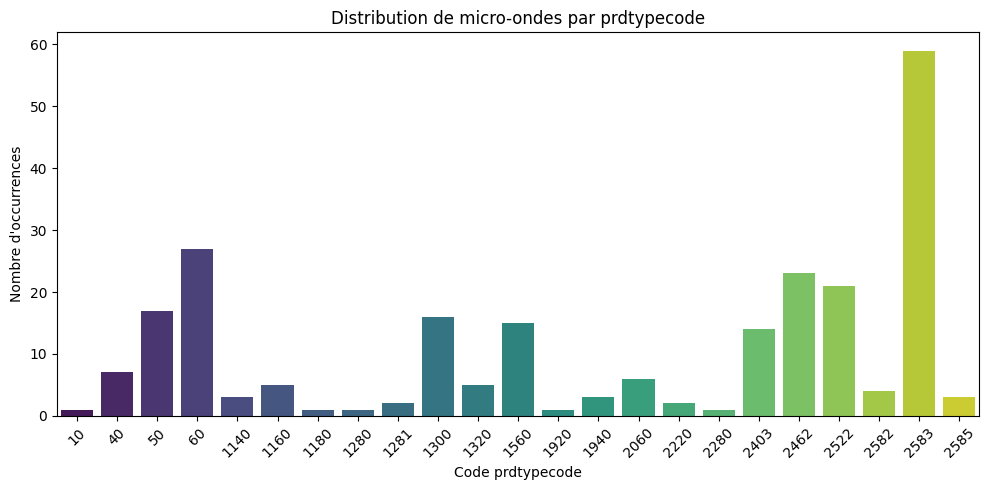

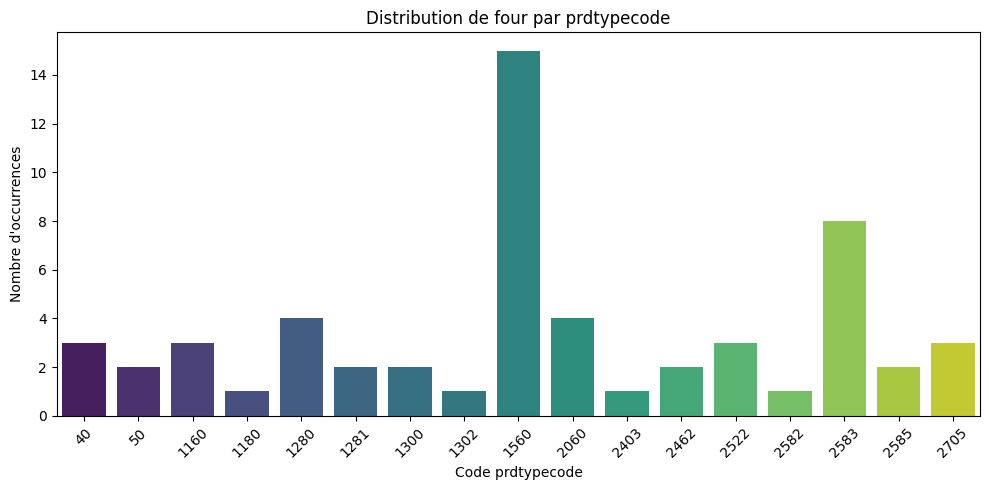

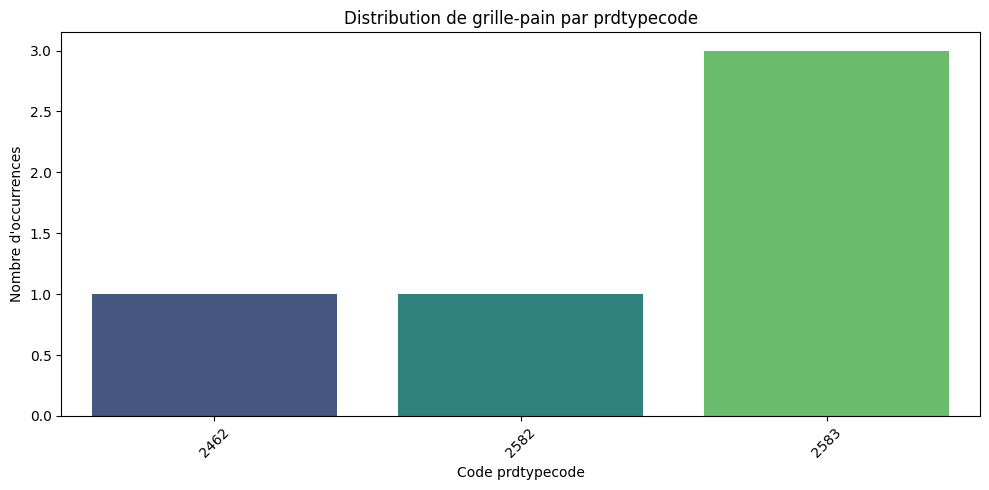

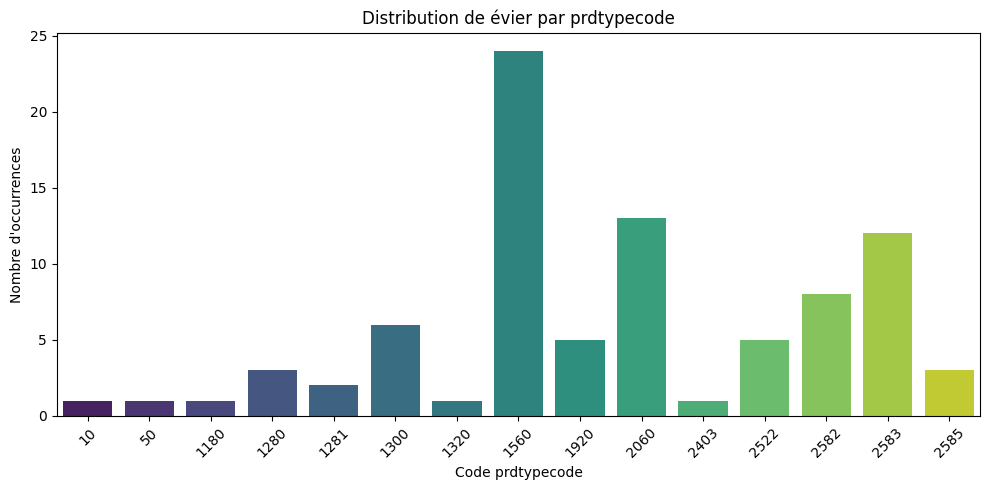

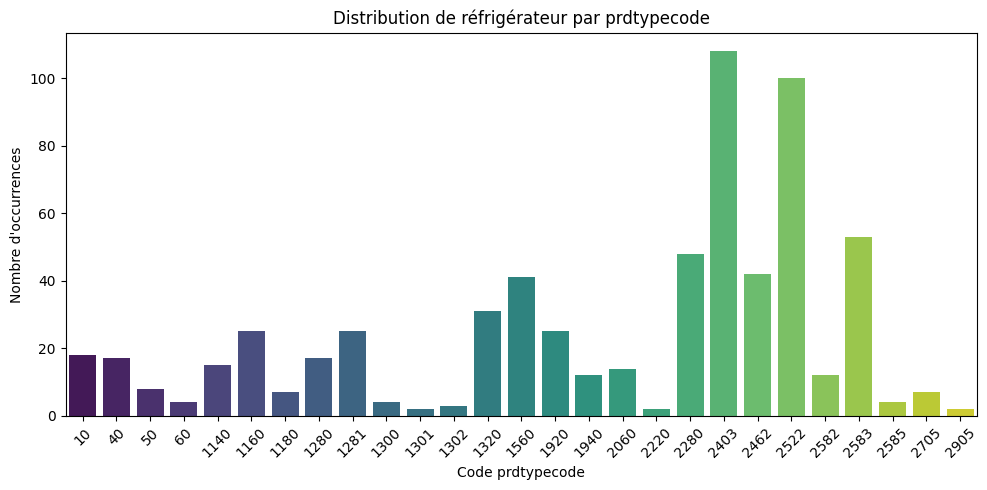

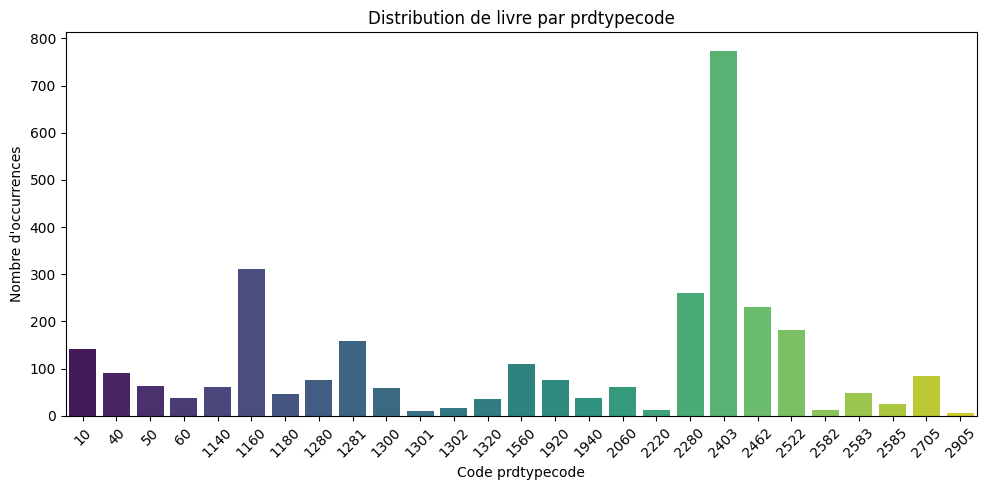

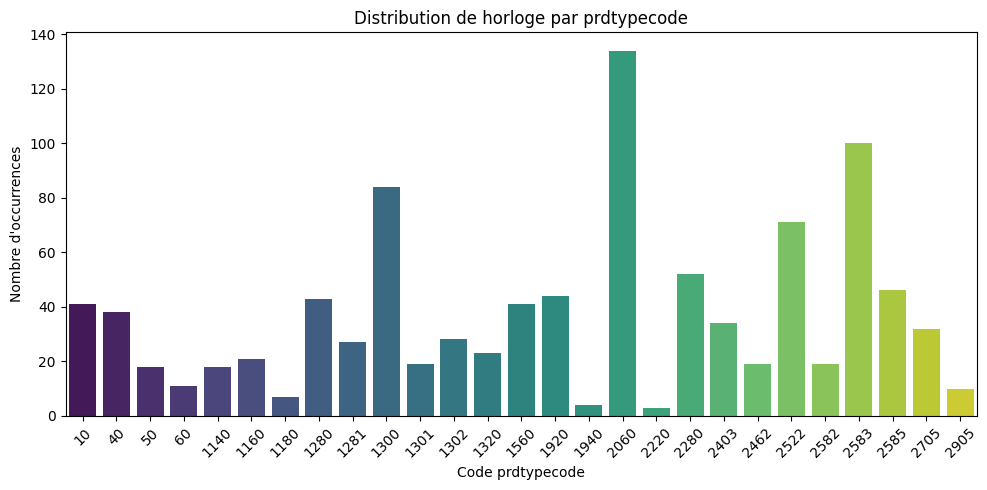

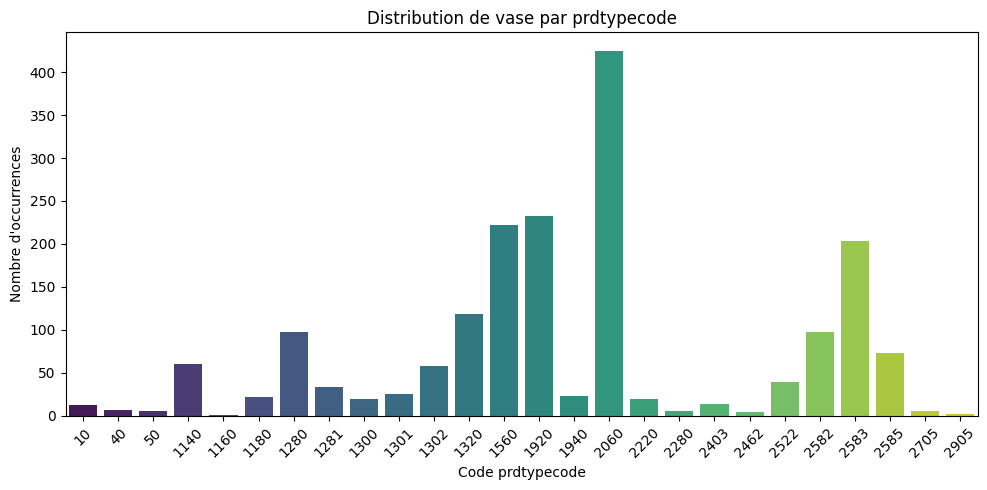

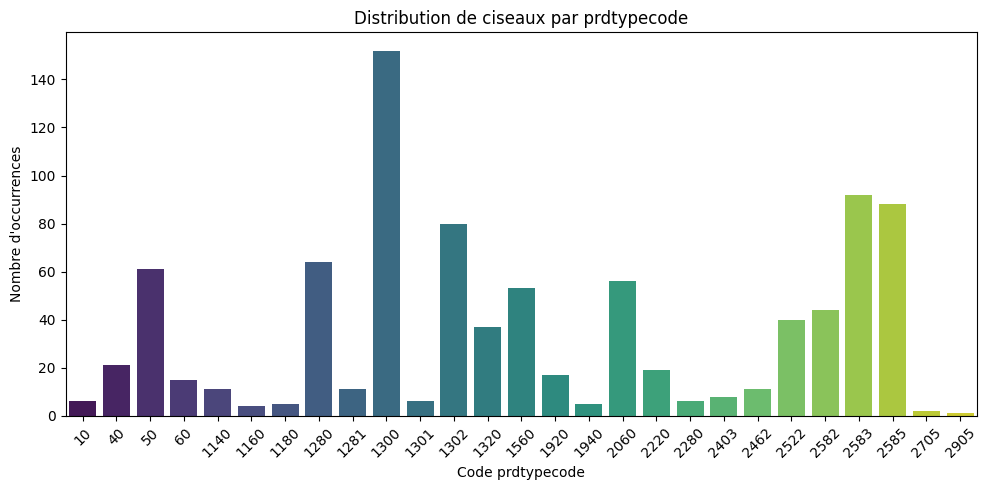

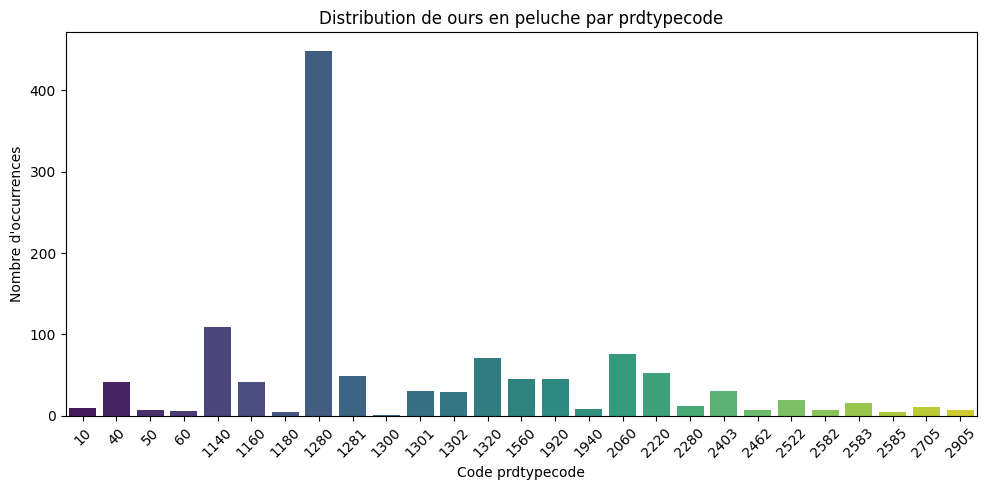

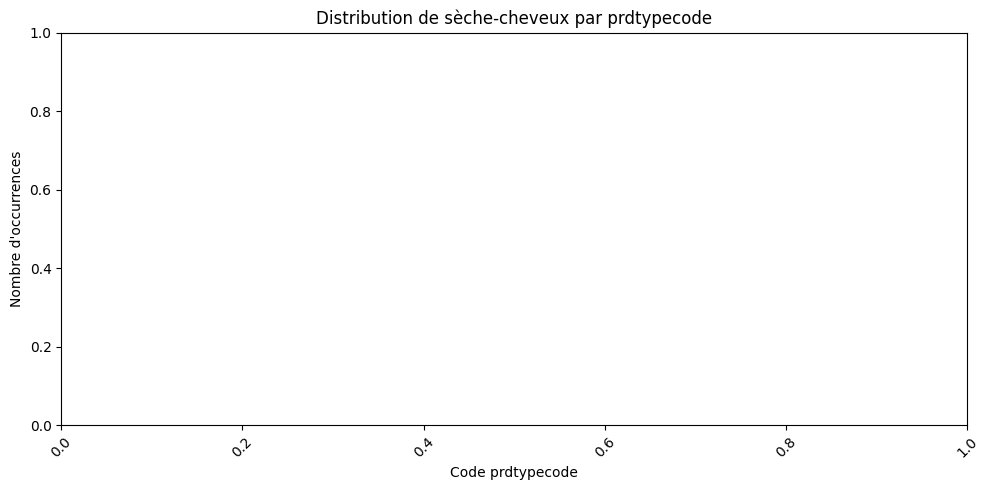

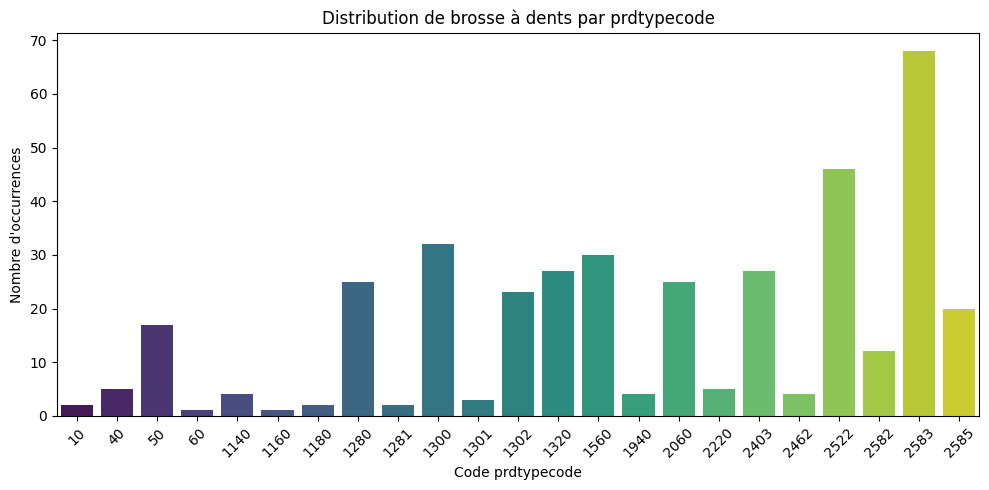

In [8]:
# Étape 1 : Calculer la distribution pour chaque classe
for cls in noms_classes_fr:
    # Filtrer le DataFrame pour les lignes où la classe est présente
    filtered_df = final_df[final_df[cls] == 1]
    
    # Compter les occurrences de chaque prdtypecode
    distribution = filtered_df['prdtypecode'].value_counts().reset_index()
    distribution.columns = ['prdtypecode', 'count']
    
    # Étape 2 : Visualiser la distribution
    plt.figure(figsize=(10, 5))
    sns.barplot(data=distribution, x='prdtypecode', y='count', palette='viridis')
    
    # Personnaliser le graphique
    plt.title(f'Distribution de {cls} par prdtypecode')
    plt.xlabel('Code prdtypecode')
    plt.ylabel('Nombre d\'occurrences')
    plt.xticks(rotation=45)  # Rotation des étiquettes pour une meilleure lisibilité
    plt.tight_layout()  # Ajuster la mise en page
    plt.show()

Nous avons des résultats intéressants. Il est vrai que la plupart des distributions ne nous apprennent rien. Cependant, il y a quelques distributions, comme celles des classes "bateau", "ours" et "TV", qui montrent qu'elles sont significativement corrélées respectivement aux codes 2583, 1280 et 1160.

(Sauvegarder en tant que yolo_hist1.png (bateau), yolo_hist2.png (ours) et yolo_hist3.png (TV))